In [2]:
#Importing the libraries to watch the 'fits' image and get the data array
import astropy
from astropy.io import fits
#Importing a library that is useful to read the original file
import pandas as pd
import pylab as plb
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pywt
from scipy.stats import chisquare
from scipy import asarray as ar,exp
#Importing a visual library with 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors 
import random
from matplotlib import cm
import matplotlib.patches as mpatches

import numpy as np
import math 
import seaborn as sns
import datetime
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 12 
plt.rcParams['xtick.labelsize'] = 12 
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['figure.figsize'] = (16, 8) 
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
plt.rcParams["axes.grid"] = False

colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']
cmap_big = cm.get_cmap('Spectral', 512)
cmap = mcolors.ListedColormap(cmap_big(np.linspace(0.7, 0.95, 256))) 
bbox_props = dict(boxstyle="round,pad=0.3", fc=colors[0], alpha=.5)

# Pre-processing steps

In [3]:
data=pd.read_csv('data.csv',sep=';')

In [4]:
data=data.rename(columns={'Data':'Day','Godzina':'hour','Minuty':'minute','Wolumen':'Load'})

In [5]:
SECONDS=np.arange(900,900*len(data)+900,900)

In [6]:
data['seconds']=SECONDS

In [7]:
LOAD=data.Load

In [8]:
from scipy import signal
load_no_line=signal.detrend(LOAD,type='linear')
#load_no_constant=signal.detrend(load_no_line,type='constant')

In [9]:
clean_load=np.array(load_no_line)-np.array(load_no_line).mean()

In [10]:
data['clean_load']=clean_load

In [11]:
data=data.drop(columns=['Load']).rename(columns={'clean_load':'Load'})

# Wavelet Transform

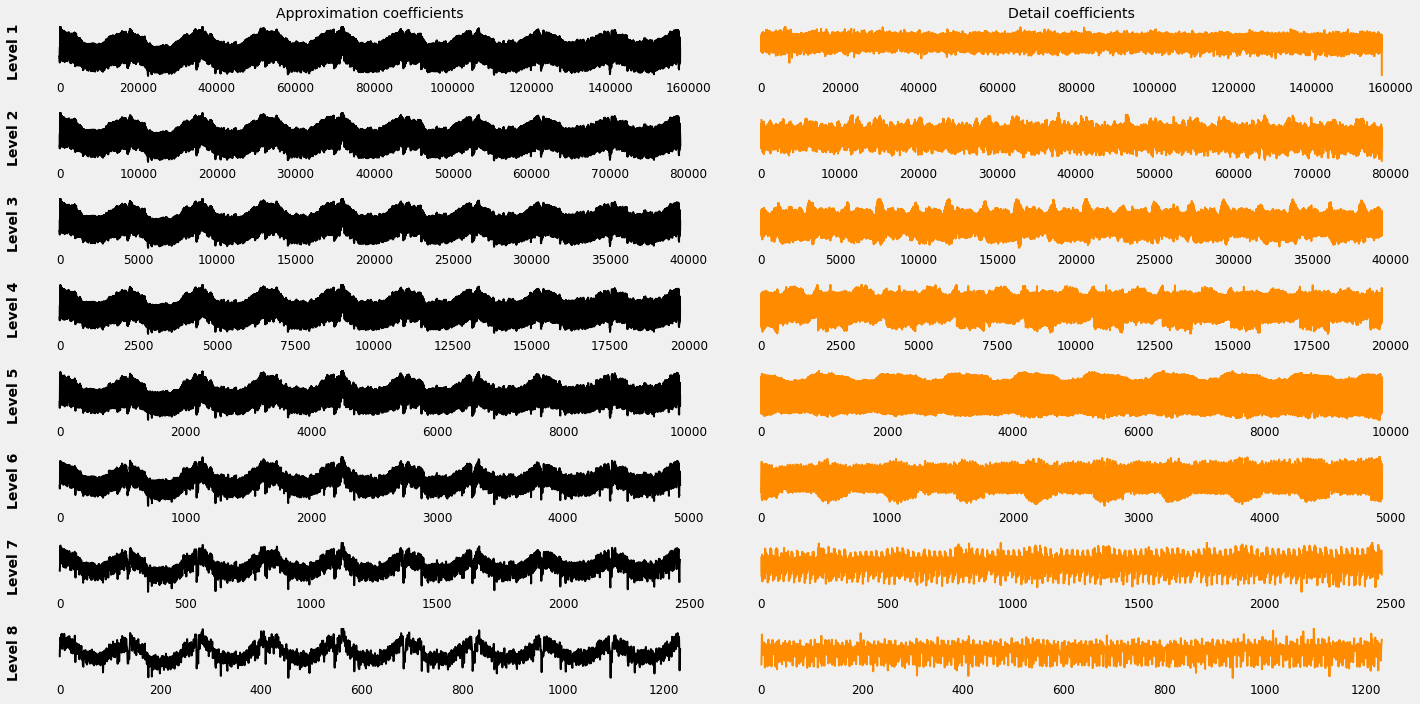

In [15]:
#Performing the Wavelet transform using a sym2
week=data
time=week.seconds.max()
sample_rate=1/900.
size= int(sample_rate*time)
t = np.linspace(0, time, num=size)
dataset = np.array(week.Load.tolist())
waveletname = 'sym2'
levels=8
fig, axarr = plt.subplots(nrows=levels, ncols=2, figsize=(20,10))
COEFF_D=[]
DATASET=[]
k=1
for ii in range(levels):
    (dataset, coeff_d) = pywt.dwt(dataset, waveletname,mode='per')
    axarr[ii, 0].plot(dataset, 'black')
    axarr[ii, 1].plot(coeff_d, 'darkorange')
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
    axarr[ii, 1].set_yticklabels([])
    #print(len(coeff_d))
    COEFF_D.append(np.repeat(coeff_d,2**k))
    DATASET.append(np.repeat(dataset,2**k))
    k=k+1
plt.tight_layout()
plt.show()

In [16]:
#Preparing the gaussian fit 
def gaus(x,a,x0,sigma):
        return a*np.exp(-(x-x0)**2/(2*sigma**2))

 

In [81]:
#Histogram of the first coefficient 
x=np.histogram(COEFF_D[0],500)[1][0:500]
y=np.histogram(COEFF_D[0],500)[0]

In [82]:
#To restrict the number of values and fit the gaussian correctly, this function has been used
def takeClosest(num,collection):
    collection=collection.tolist()
    collection=np.array(collection)
    if num>=0:
        collection=np.abs(collection[np.where(collection>0)])
        a= min(collection,key=lambda x:abs(x-abs(num)))
    else:
        collection=np.abs(collection[np.where(collection<0)])

        a= -min(collection,key=lambda x:abs(x-abs(num)))
    return a

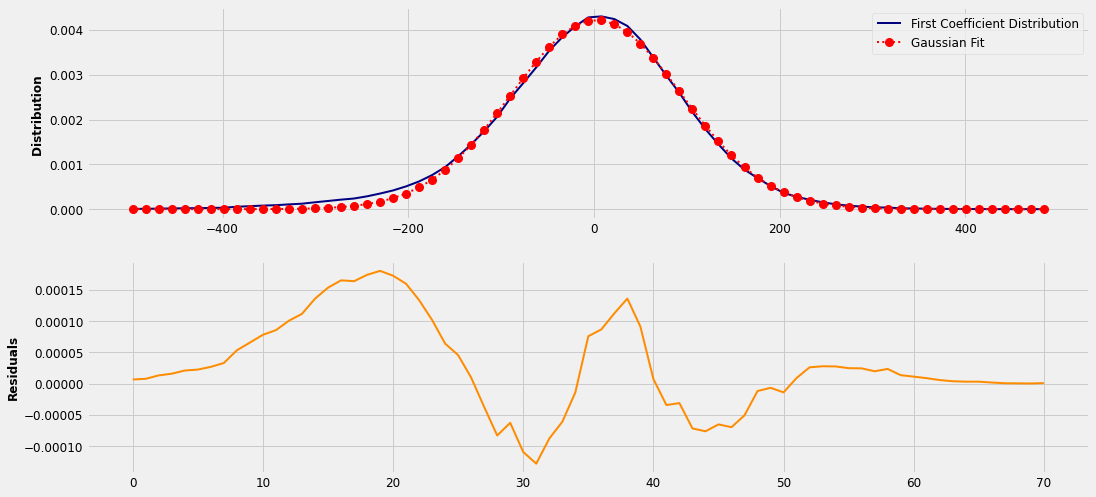

In [90]:
#Gaussian Fit
x_try=x
b=x.tolist().index(takeClosest(500,x))
a=x.tolist().index(takeClosest(-500,x))
x=x[a:b]
y=y[a:b]


val_medio=x[int(len(x)/2)]
n = len(x)                       #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-val_medio)**2)/n        #note this correction
p0 = [max(y),val_medio,10]
popt,pcov = curve_fit(gaus,x,y,p0=p0)
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_ylabel('Distribution ')
ax1.plot(x,y,'navy',label='First Coefficient Distribution')
ax1.grid(True)
plt.ylabel('Residuals')
ax1.plot(x,gaus(x,*popt),'ro:',label='Gaussian Fit')
ax1.legend()
res = y - gaus(x,*popt)
ax2.plot(res,color='darkorange')
ax2.grid(True)
plt.show()



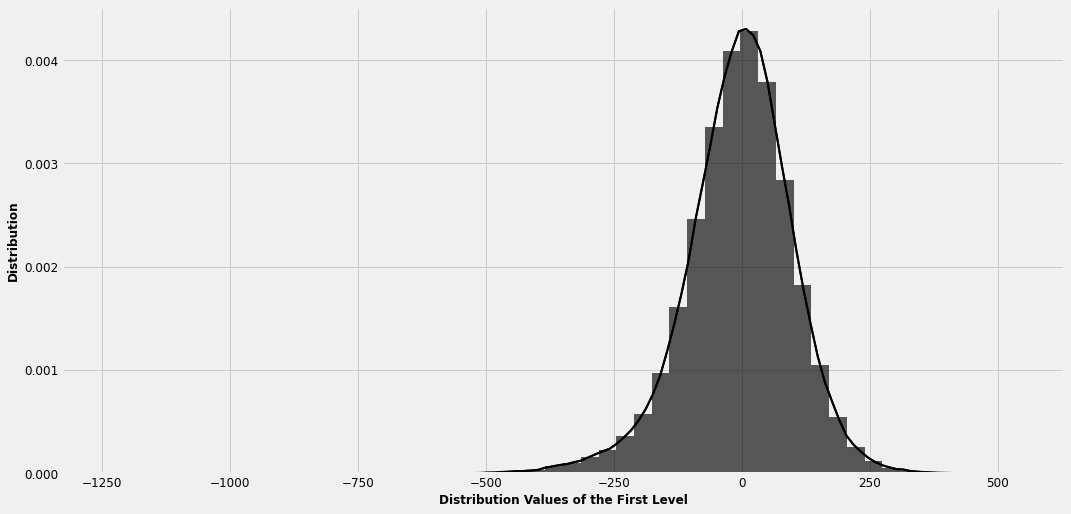

In [89]:
x=sns.distplot(COEFF_D[0],color='k').get_lines()[0].get_data()[0][a:b]
y=sns.distplot(COEFF_D[0],color='k').get_lines()[0].get_data()[1][a:b]
plt.ylabel('Distribution')
plt.xlabel('Distribution Values of the First Level')
plt.grid(True)

In [91]:
Sigma=popt[2]

In [92]:
K=np.arange(0,13.25*Sigma,0.1)

91.76859650879979

In [477]:
#tot_recon=LEVELS

In [479]:
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [480]:
def res_distribution(reconstruction):
    res=week.Load-reconstruction
    LIST=res.round()
    NEW_LIST=[]
    for l in LIST:
        NEW_LIST.append(roundup(l))
    A=pd.DataFrame({'A':pd.Series(NEW_LIST).value_counts()})
    A=A.reset_index()
    A=A.sort_values(by='index')
    x=A['index']
    y=A['A']
    a=x.tolist().index(-500)
    b=x.tolist().index(500)+1
    x=x.tolist()[a:b]
    y=A['A'].tolist()[a:b]
    x,y=np.array(x),np.array(y)
    return [x,y]

In [482]:
def coeff_from_th(threshold):
    lim_1=-threshold*Sigma
    lim_2=-lim_1
    coeff_0=np.array(COEFF_D[0].copy())
    #mask = np.where((coeff_0<lim_2) & (coeff_0>lim_1))
    coeff_0[np.where((coeff_0<lim_2) & (coeff_0>lim_1))]=0
    MAX=(coeff_0+DATASET[0]).max()
    #MAX=(coeff_0+DATASET[0]).max()
    return coeff_0*(week.Load.max()/MAX)

In [483]:
def coeff_distribution(coefficient):
    LIST=coefficient.round()  
    
    NEW_LIST=[]
    for l in LIST:
        NEW_LIST.append(roundup(l))
    A=pd.DataFrame({'A':pd.Series(NEW_LIST).value_counts()})
    A=A.reset_index()
    A=A.sort_values(by='index')
    x=A['index']
    y=A['A']
    a=x.tolist().index(-200)
    b=x.tolist().index(200)+1
    x=x.tolist()[a:b]
    y=A['A'].tolist()[a:b]
    x,y=np.array(x),np.array(y)
    return [x,y]
    

In [485]:
opt_sigma=np.arange(0.0,0.35,0.01)
RMSE=[]
for sig in opt_sigma:
    RMSE.append(np.sqrt(mean_squared_error(recons_from_th(sig),data.Load)))

In [486]:
def recons_from_th(threshold):
    lim_1=-threshold*Sigma
    lim_2=-lim_1
    coeff_0=np.array(COEFF_D[0].copy())
    #mask = np.where((coeff_0<lim_2) & (coeff_0>lim_1))
    coeff_0[np.where((coeff_0<lim_2) & (coeff_0>lim_1))]=0
    level_0=coeff_0+DATASET[0]
    MAX=level_0.max()
    return level_0*(week.Load.max()/MAX)


In [504]:
np.where((coeff_0<lim_2) & (coeff_0>lim_1))[0]

array([     0,      1,      2, ..., 315643, 315644, 315645])

In [596]:
threshold=0
ZEROS=[]
for i in range(101):
    #Sigma=Sigma+0.1
    threshold=threshold+0.01
    lim_1=-threshold*Sigma
    lim_2=-lim_1
    coeff_0=np.array(COEFF_D[0].copy())
    zero_list=np.where((coeff_0<lim_2) & (coeff_0>lim_1))[0]
    ZEROS.append(len(zero_list))
    #mask = np.where((coeff_0<lim_2) & (coeff_0>lim_1))
    if len(zero_list)==len(coeff_0):
        zero_th=threshold
        break
    #threshold=threshold+1.

In [597]:
full_th=np.arange(0,1.+0.01,0.01)
print(len(full_th))
fir_v=data.Load
corr_coeff=[]
for t in full_th:
    sec_v=recons_from_th(t)
    corr_coeff.append(np.corrcoef(fir_v,sec_v-fir_v)[0][1])
corr_coeff=np.abs(np.array(corr_coeff))

101


In [599]:
corr_coeff.min(),ZEROS[corr_coeff.argmin()],full_th[corr_coeff.argmin()]

(5.7200901495973264e-05, 229436, 0.84)

In [582]:
best_th=np.arange(0,full_th[corr_coeff.argmin()],0.1)
best_coeff=[]
for t in best_th:
    sec_v=recons_from_th(t)
    best_coeff.append(np.corrcoef(fir_v,sec_v-fir_v)[0][1])

In [583]:
best_coeff

[0.009286868248294838,
 0.009237017335551328,
 0.009096678966316307,
 0.008780350862248787,
 0.007989408527776845,
 0.0065960150546366565,
 0.004884310417362596,
 0.00313045966425911,
 0.0008341608426960051,
 -0.0020010568115951493]

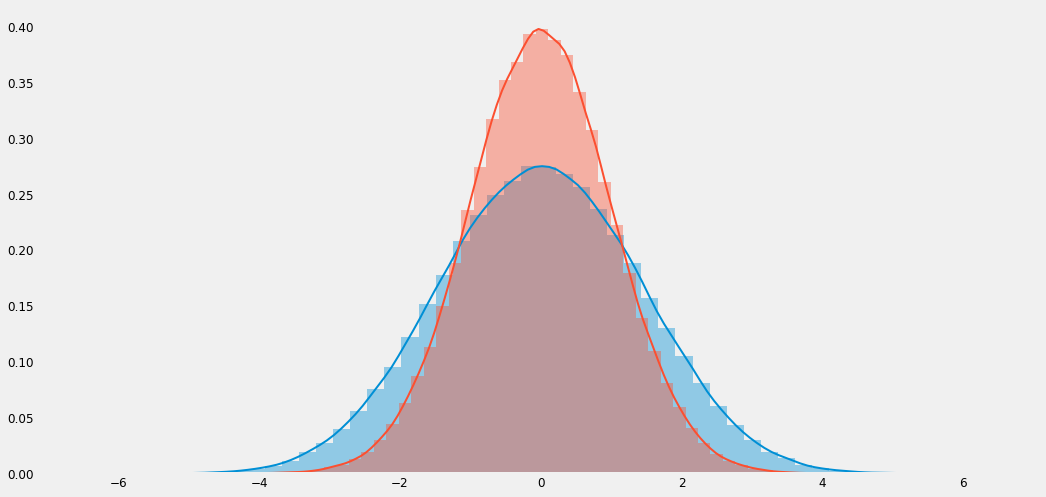

In [641]:
y=1*np.sin(4*np.arange(0,2*np.pi+2*np.pi/100000,np.pi/100000))+1*np.cos(43*np.arange(0,2*np.pi+2*np.pi/100000,np.pi/100000
                                                                            ))
noise= np.random.normal(0,1,len(y))


sns.distplot(y+noise)
sns.distplot(noise)
#plt.plot(y+noise)

In [643]:
np.corrcoef(noise,y)

array([[ 1.        , -0.00119971],
       [-0.00119971,  1.        ]])

In [646]:
np.corrcoef(DATASET[0],COEFF_D[0])

array([[1.        , 0.10798689],
       [0.10798689, 1.        ]])

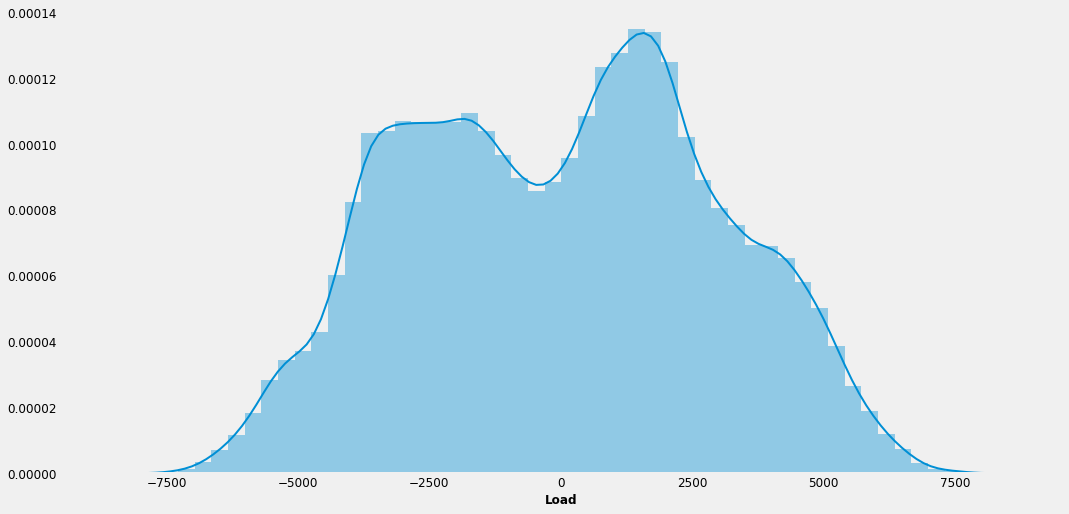

In [606]:
sns.distplot(week.Load)
#sns.distplot(COEFF_D[0])

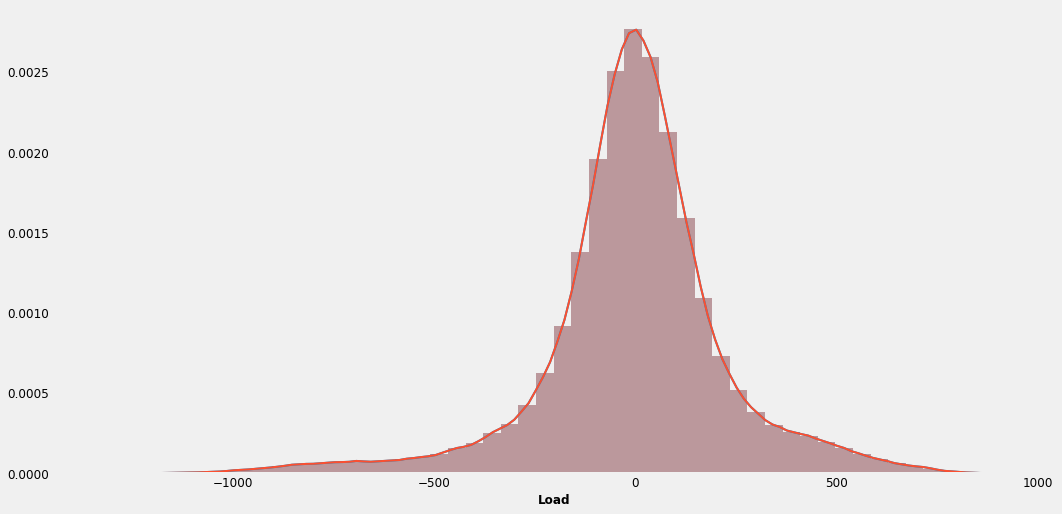

0.0


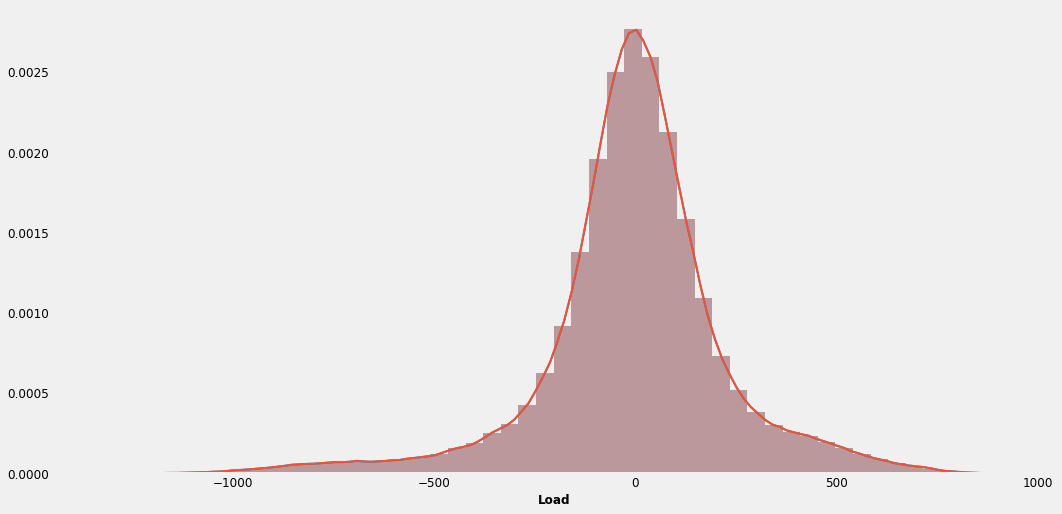

0.1


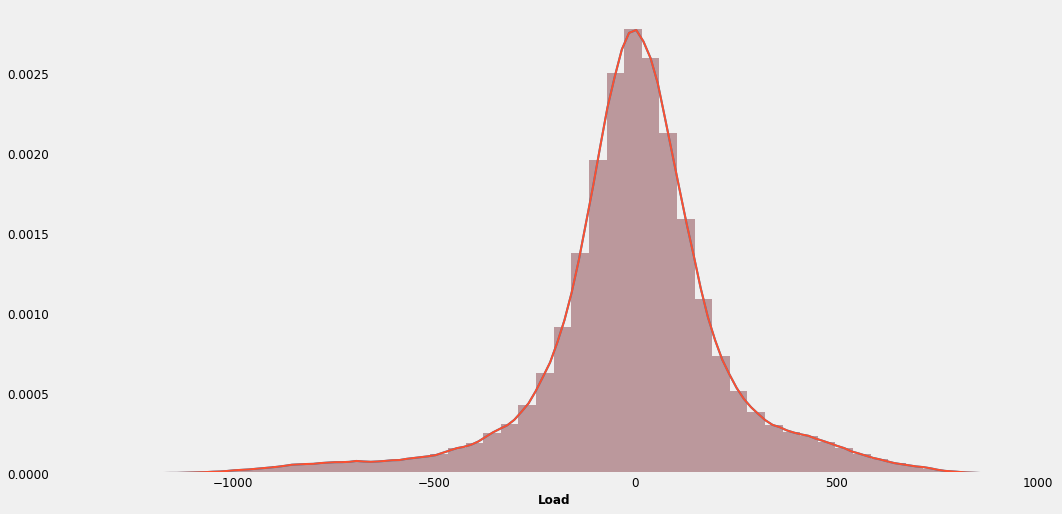

0.2


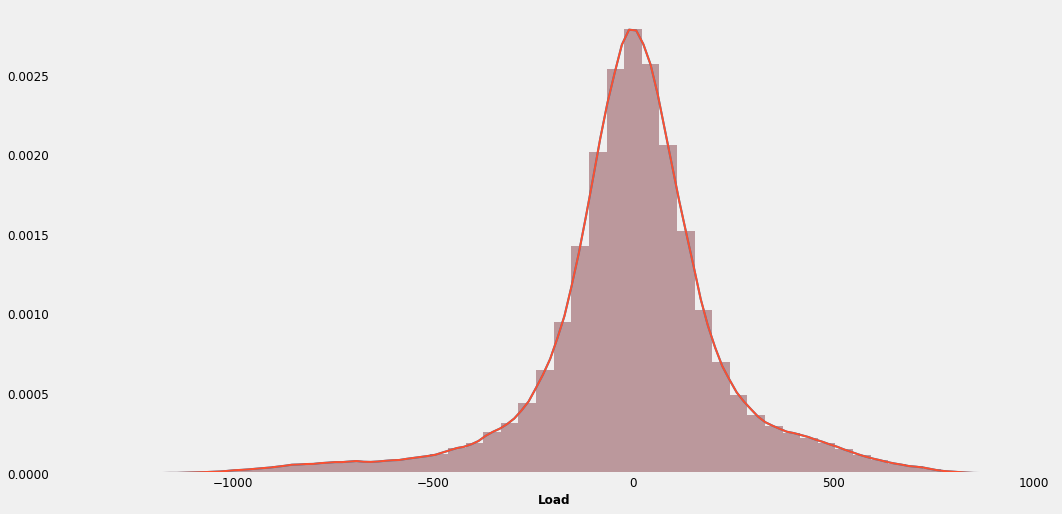

0.30000000000000004


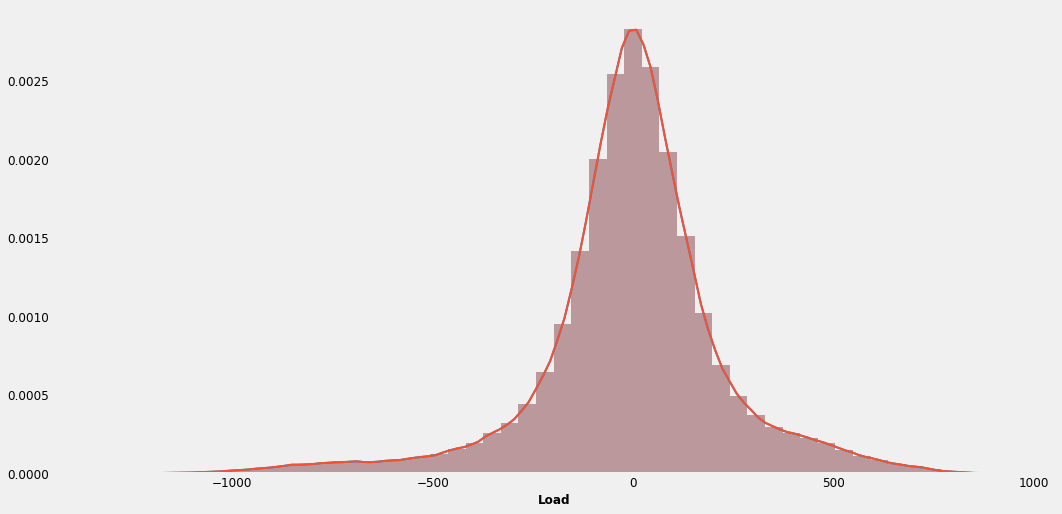

0.4


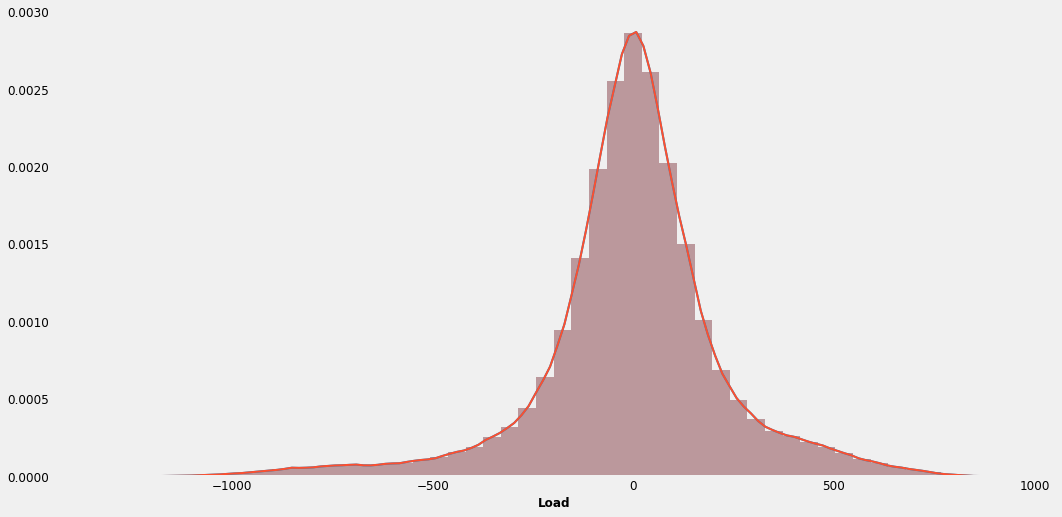

0.5


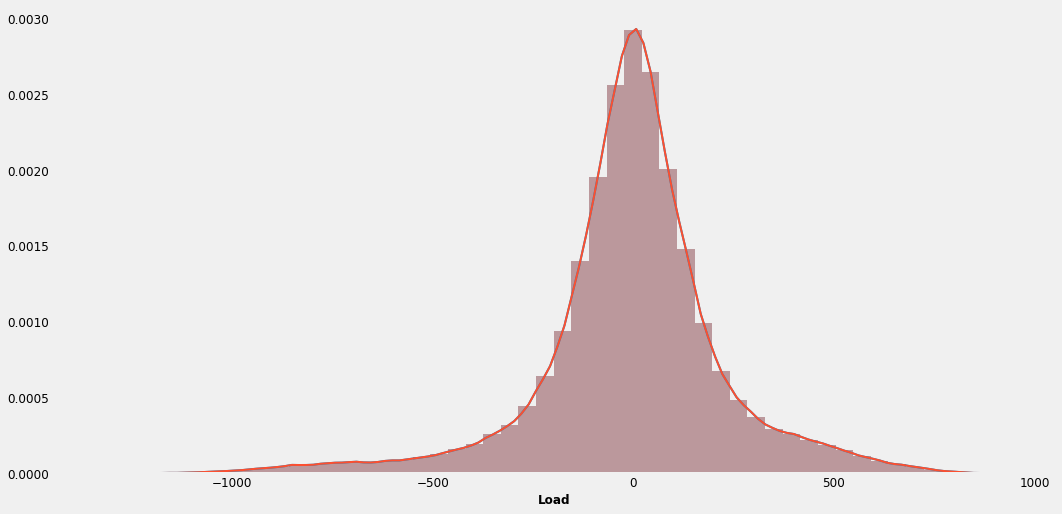

0.6000000000000001


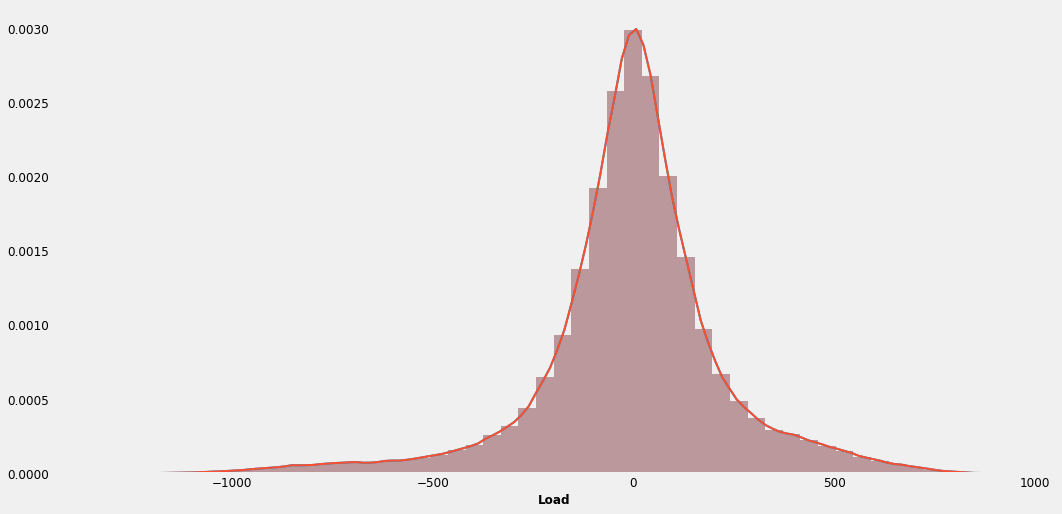

0.7000000000000001


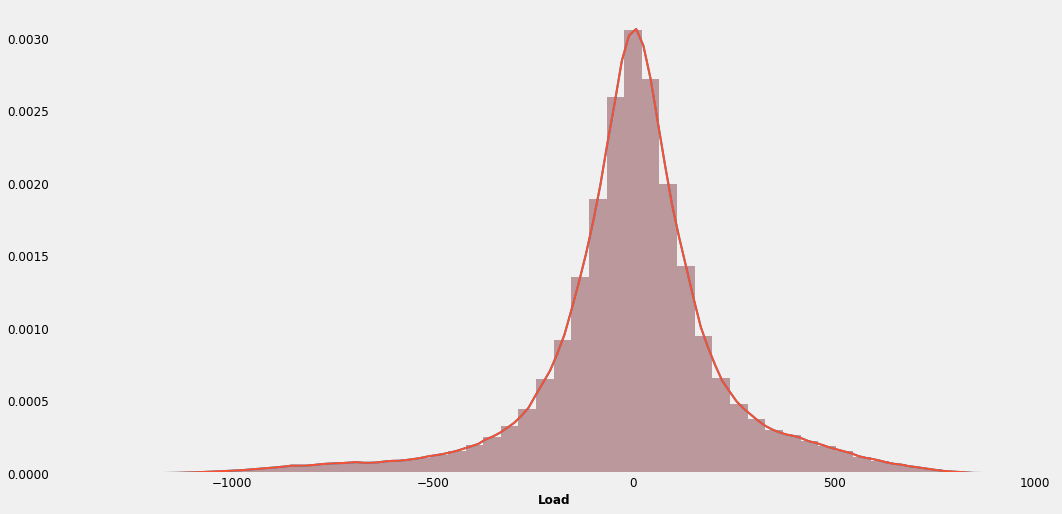

0.8


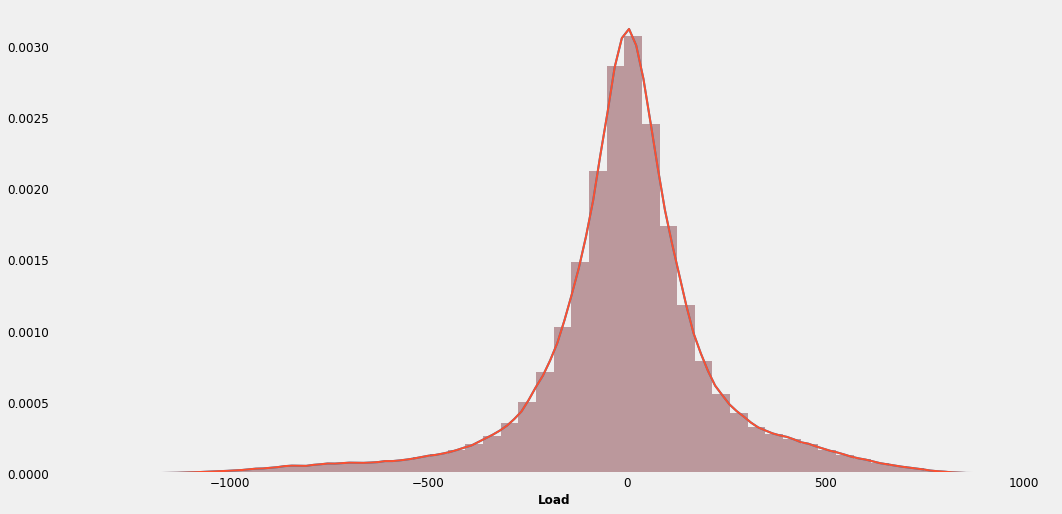

0.9


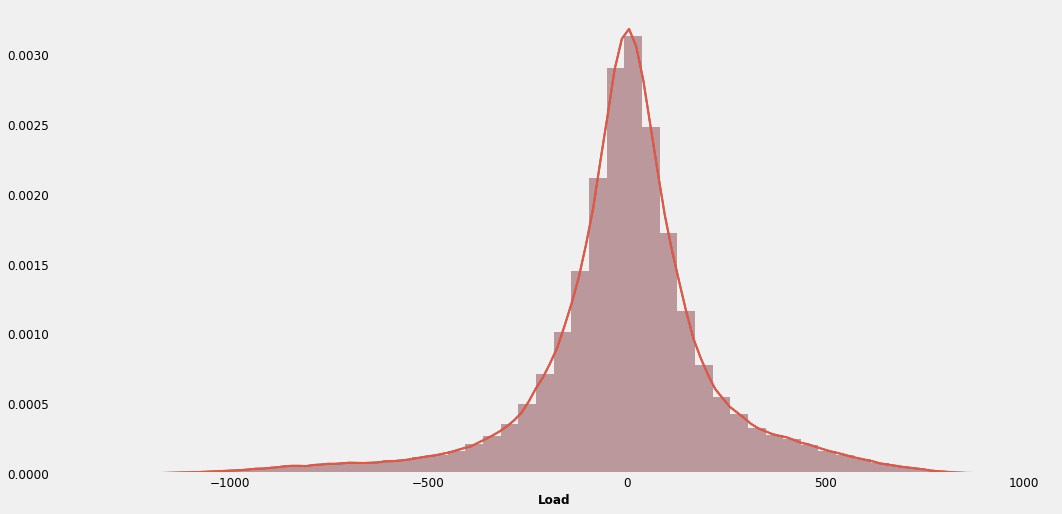

1.0


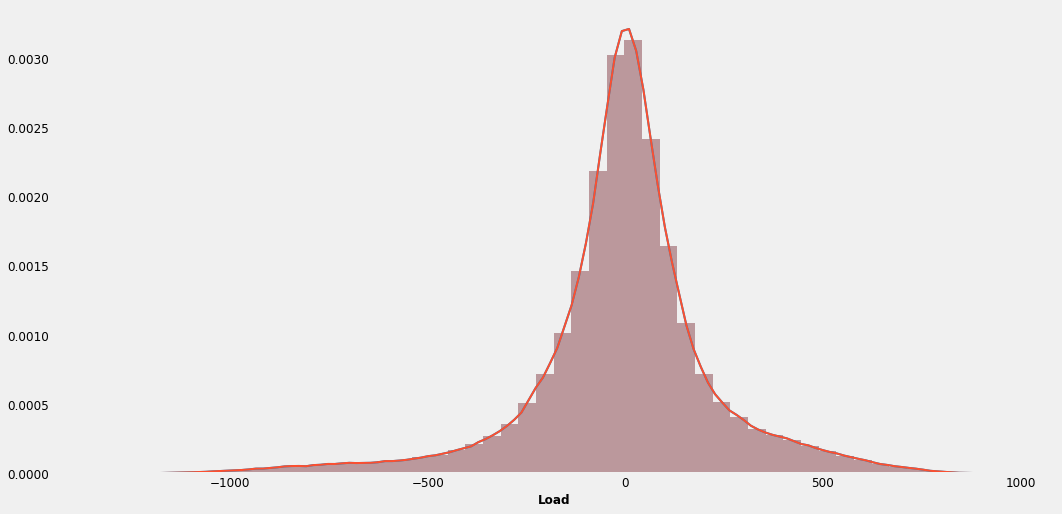

1.1


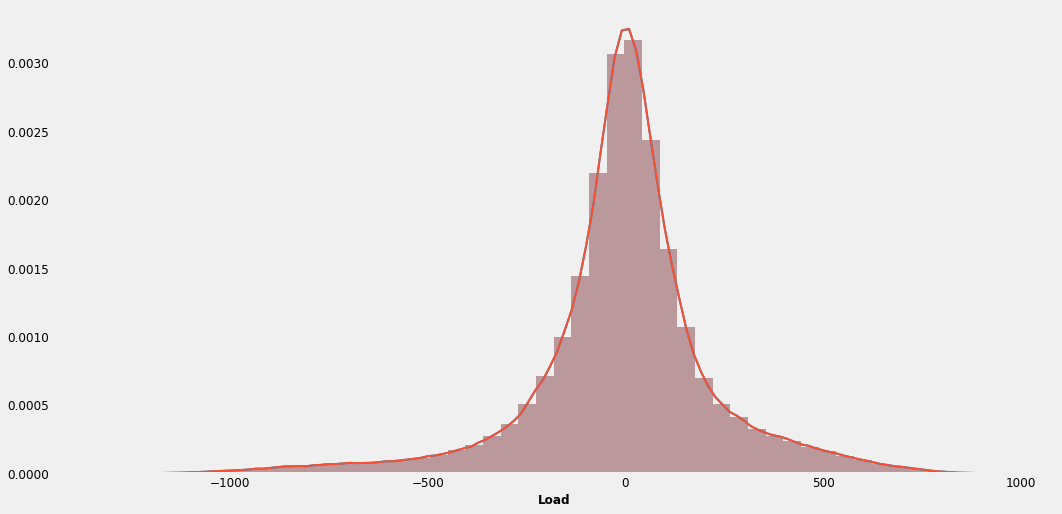

1.2000000000000002


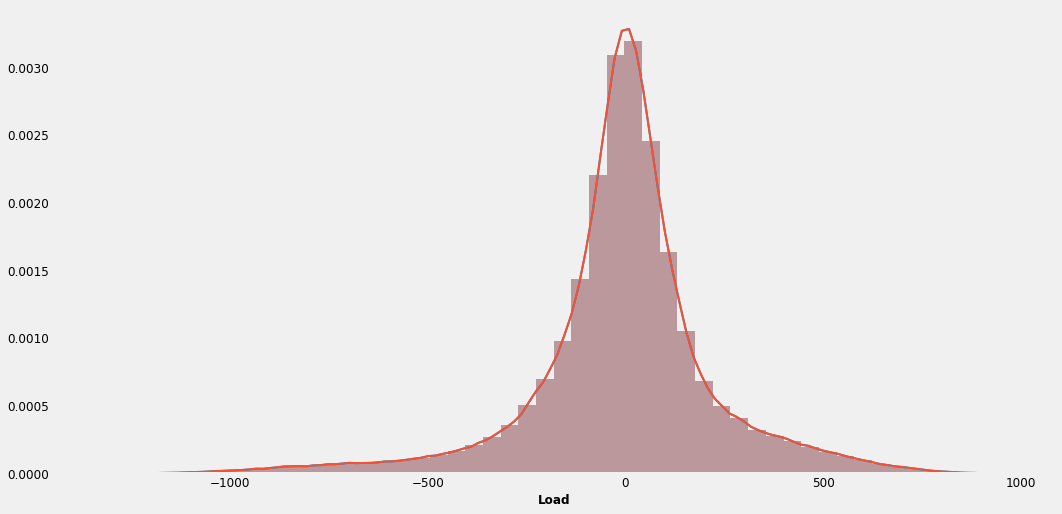

1.3


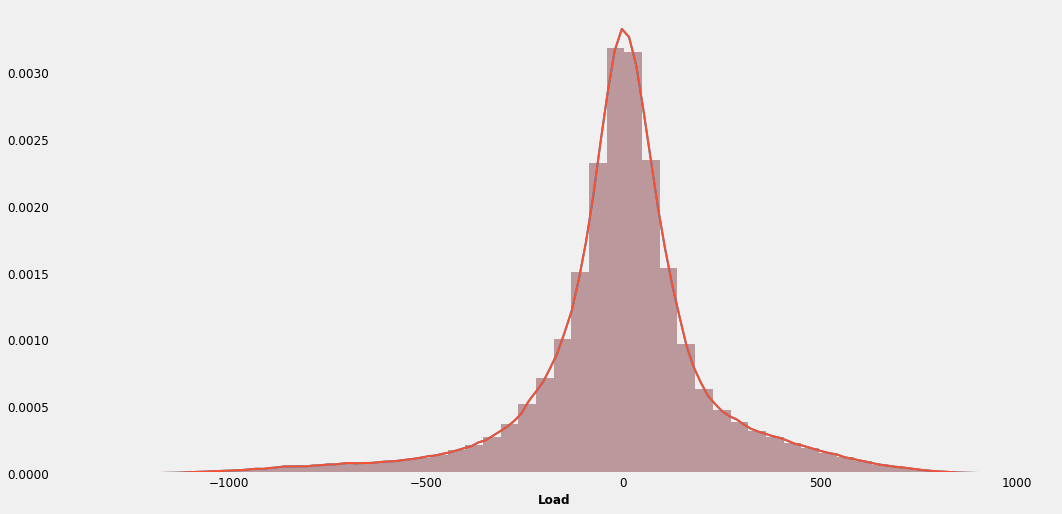

1.4000000000000001


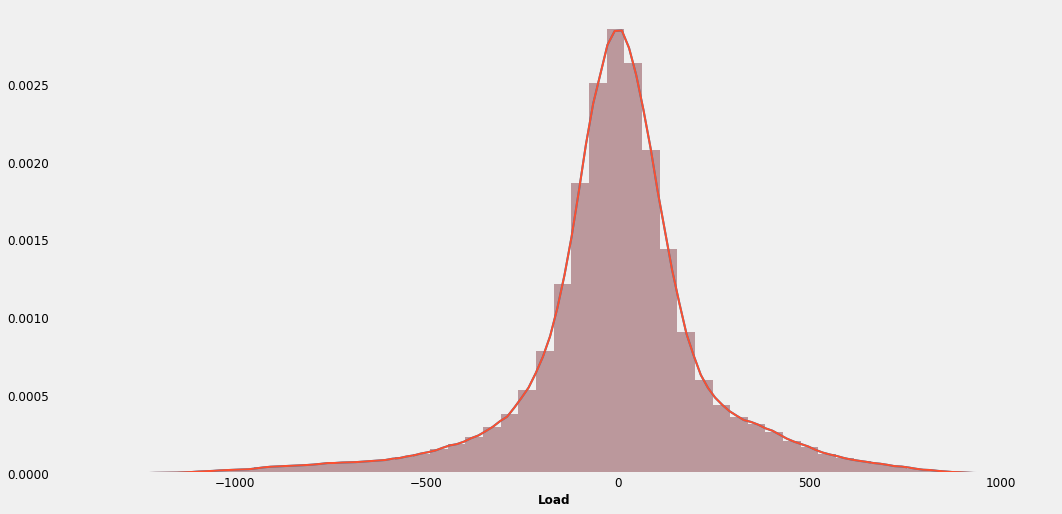

1.5


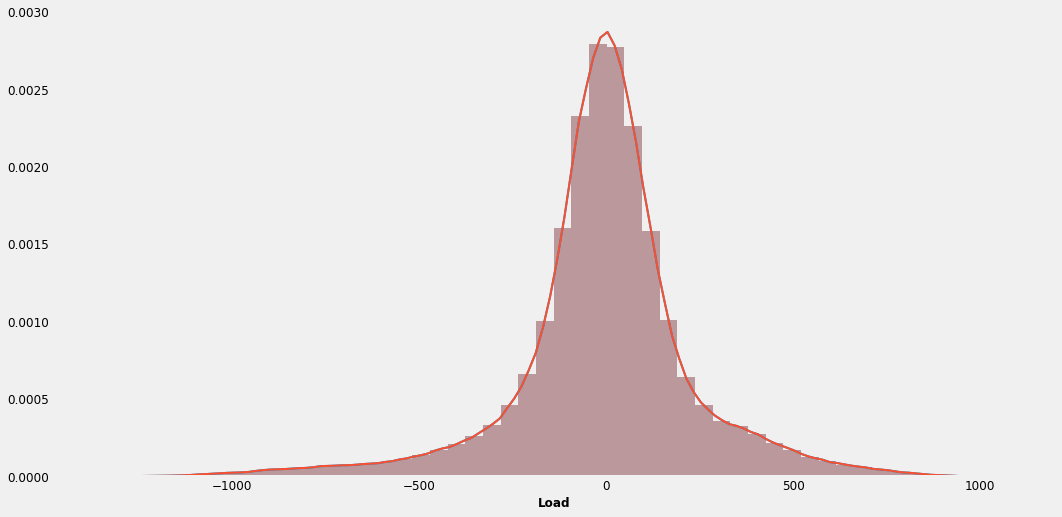

1.6


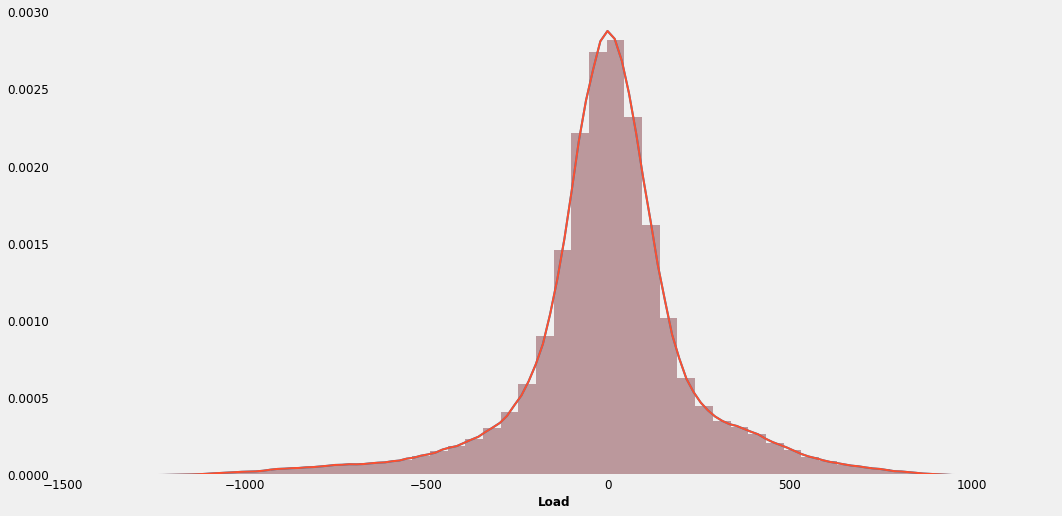

1.7000000000000002


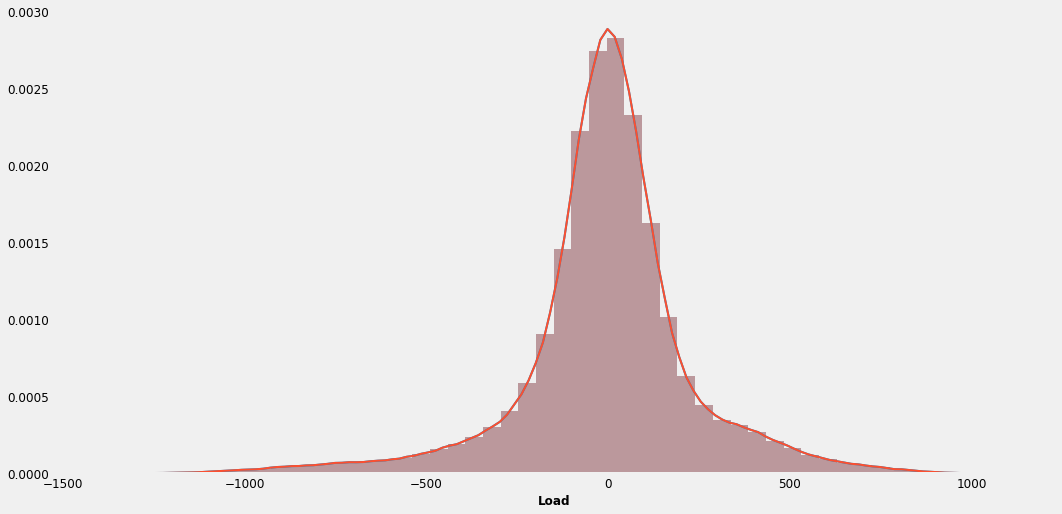

1.8


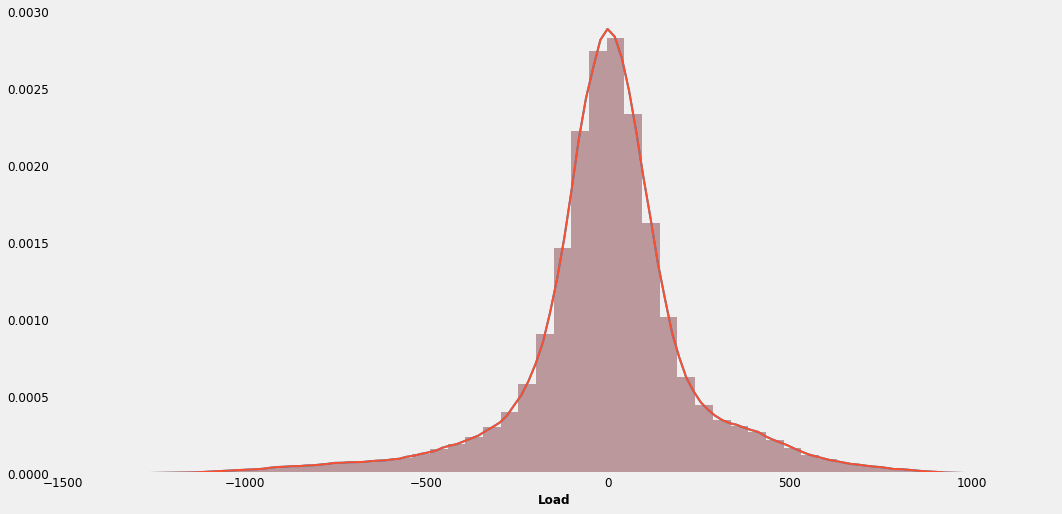

1.9000000000000001


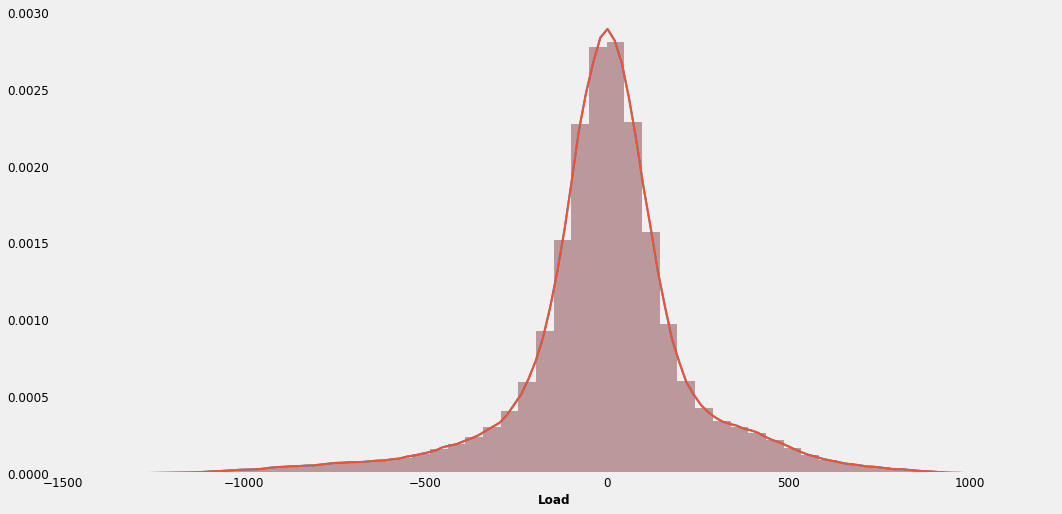

2.0


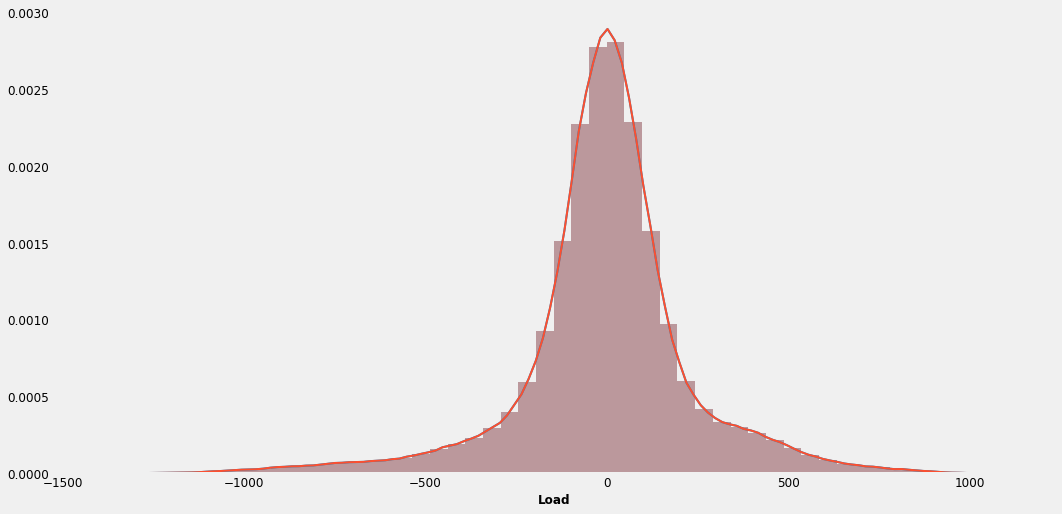

2.1


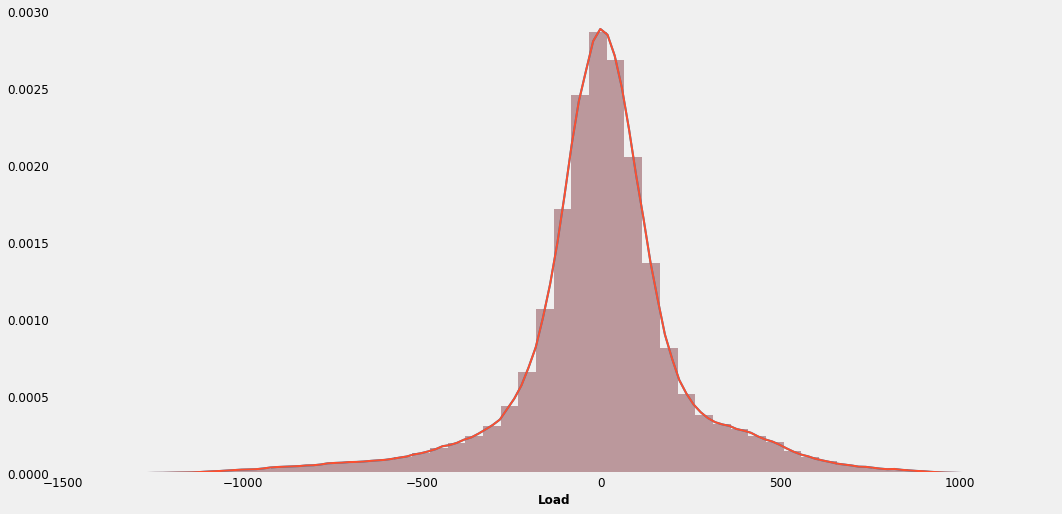

2.2


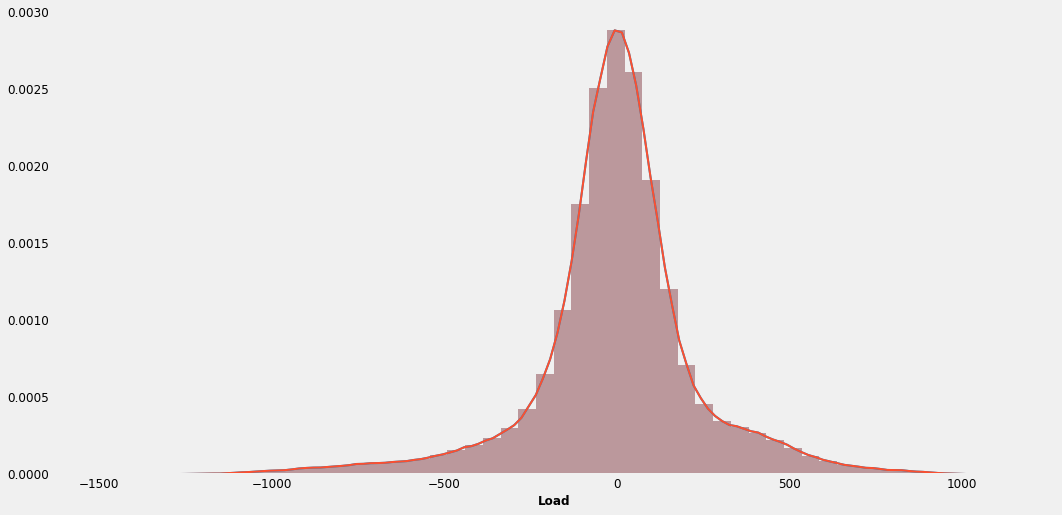

2.3000000000000003


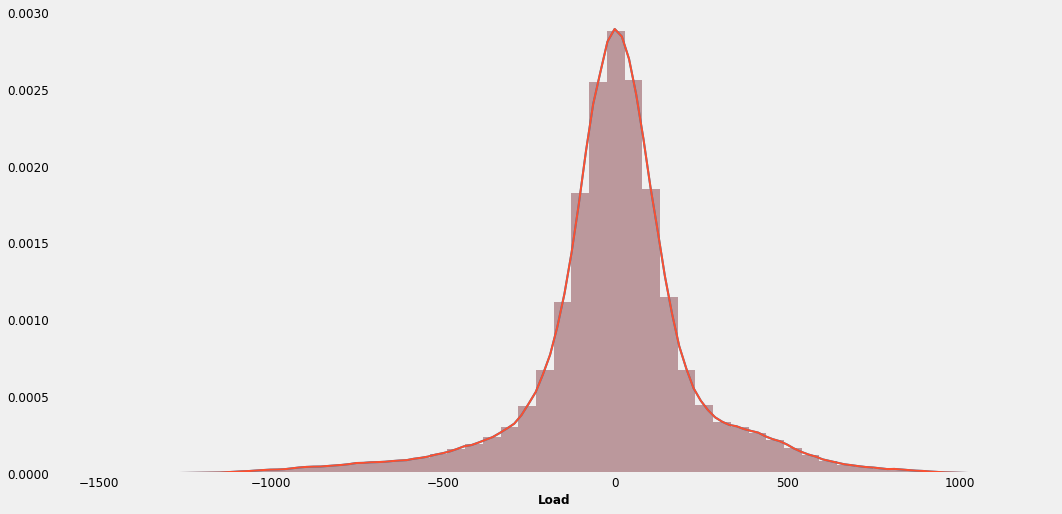

2.4000000000000004


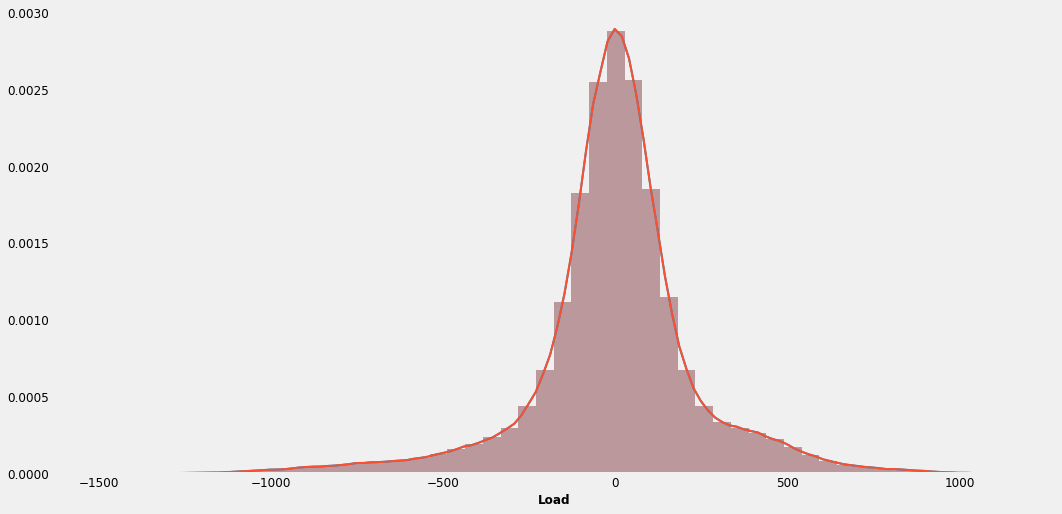

2.5


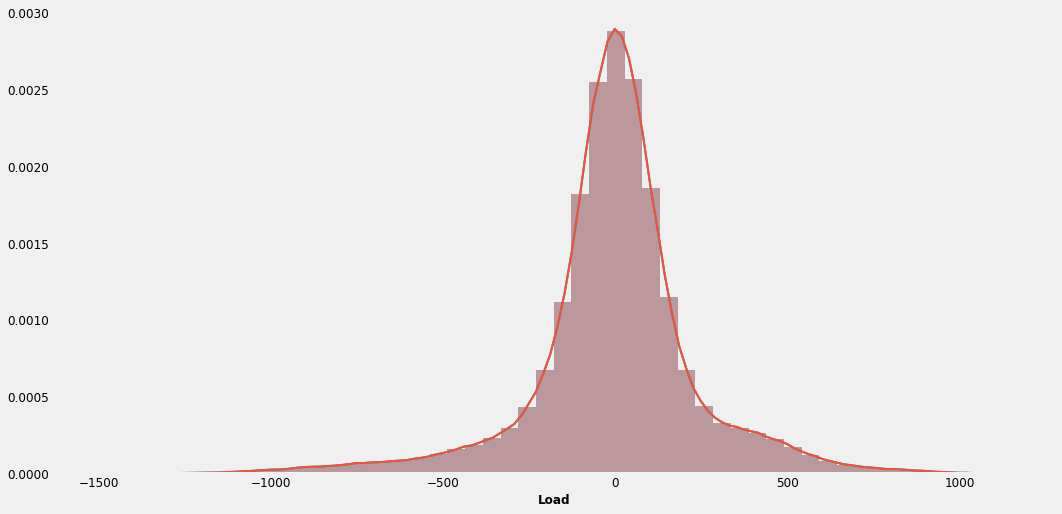

2.6


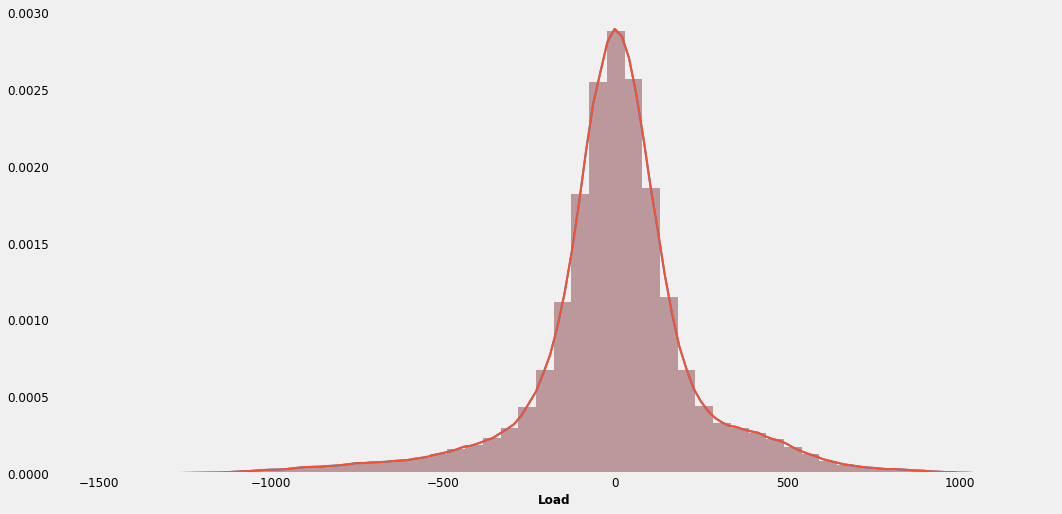

2.7


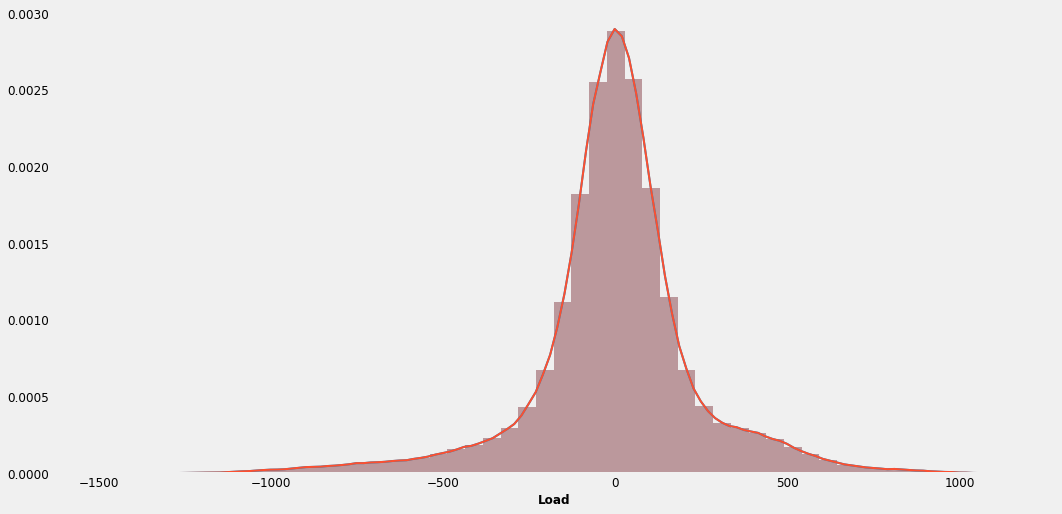

2.8000000000000003


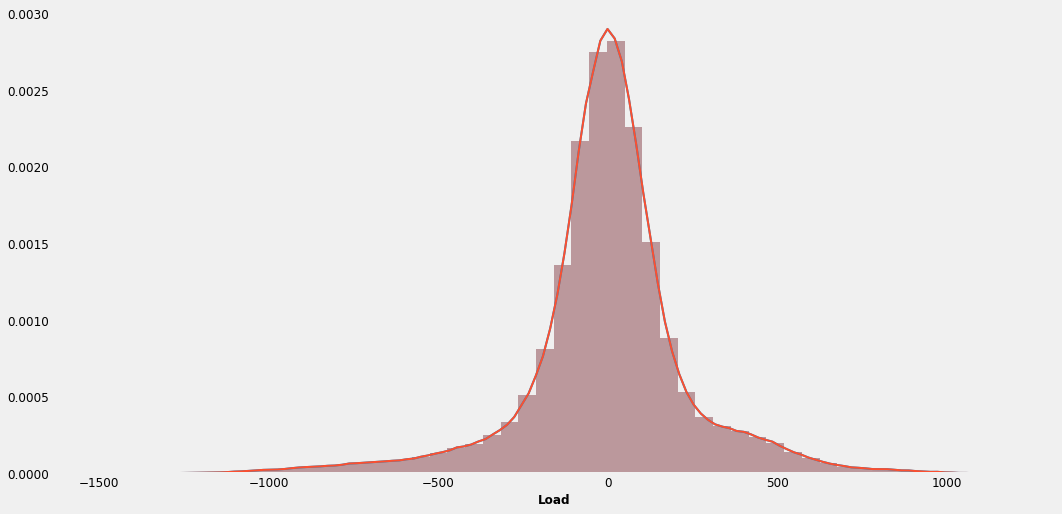

2.9000000000000004


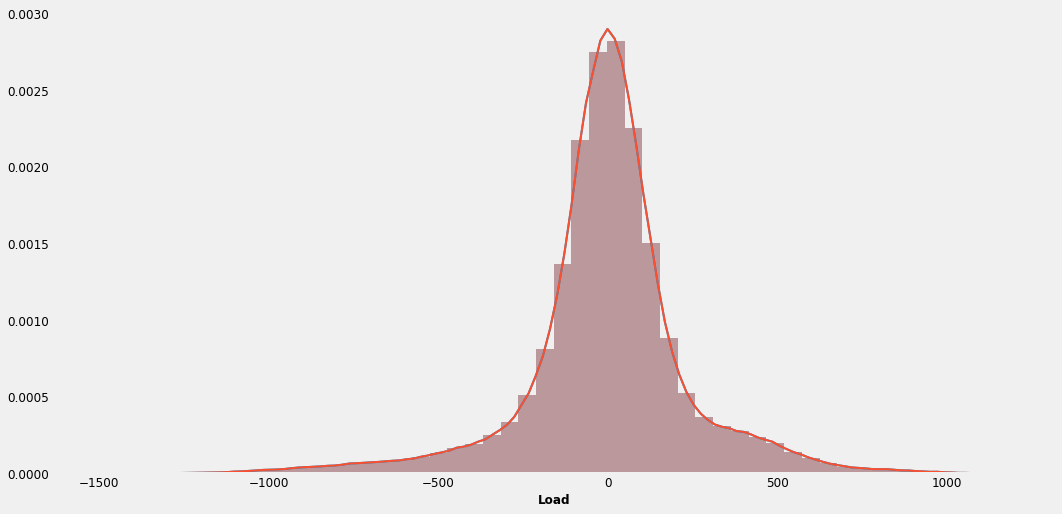

3.0


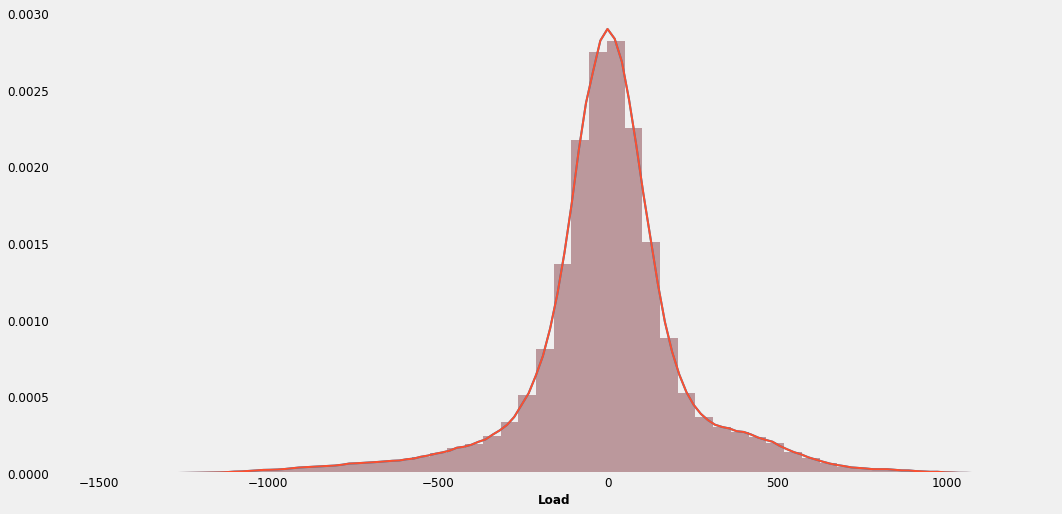

3.1


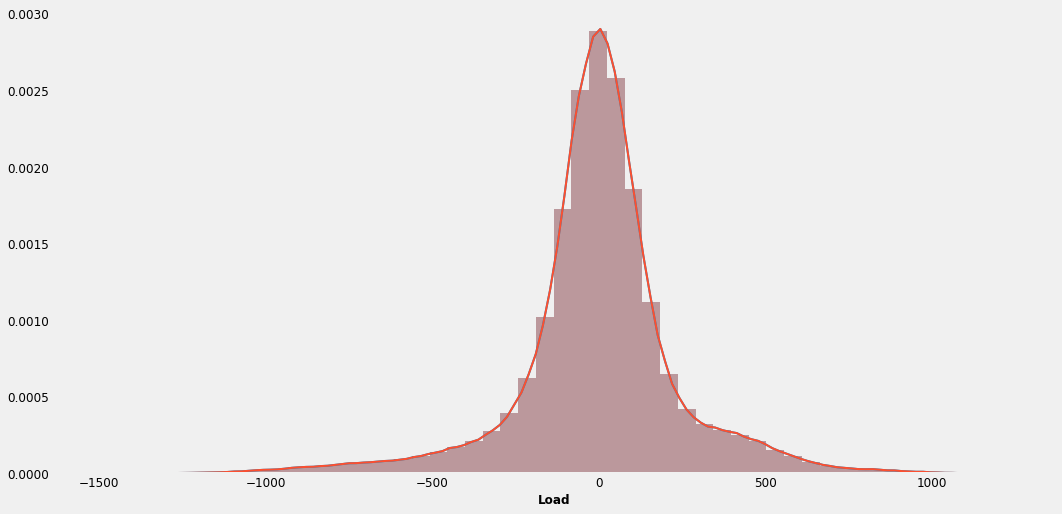

3.2


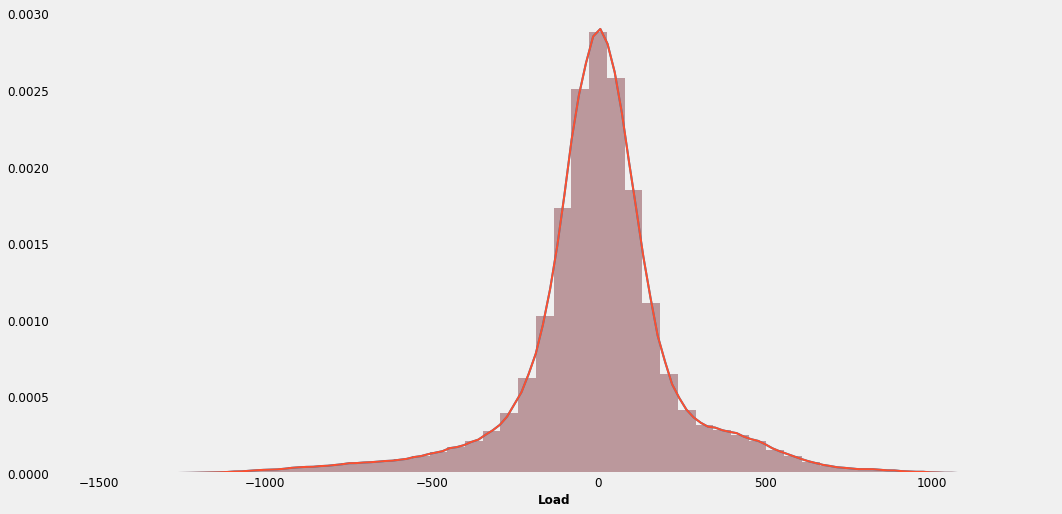

3.3000000000000003


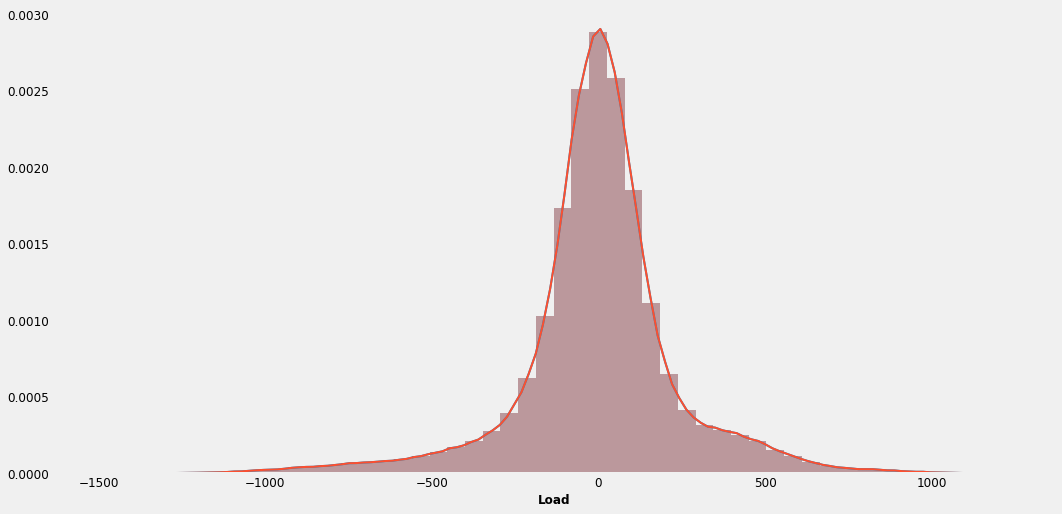

3.4000000000000004


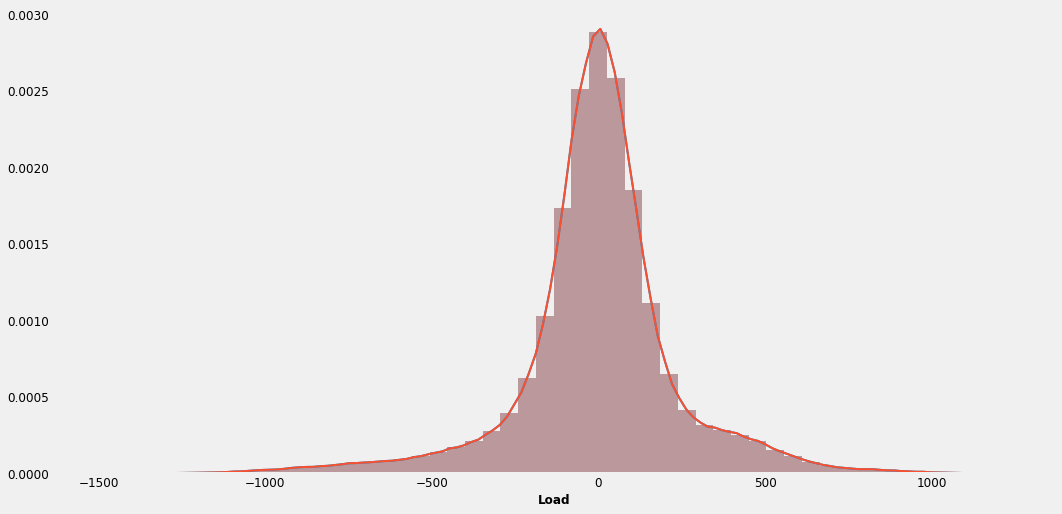

3.5


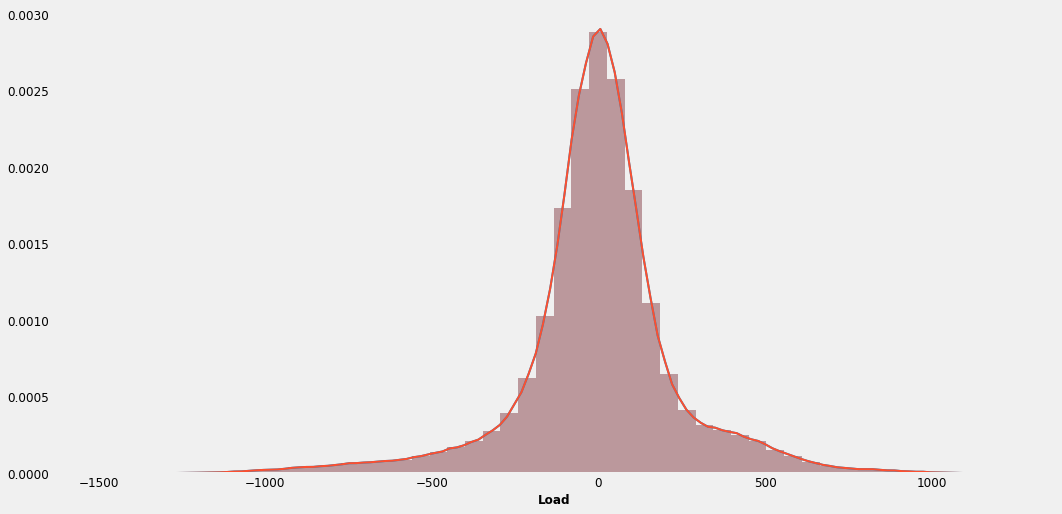

3.6


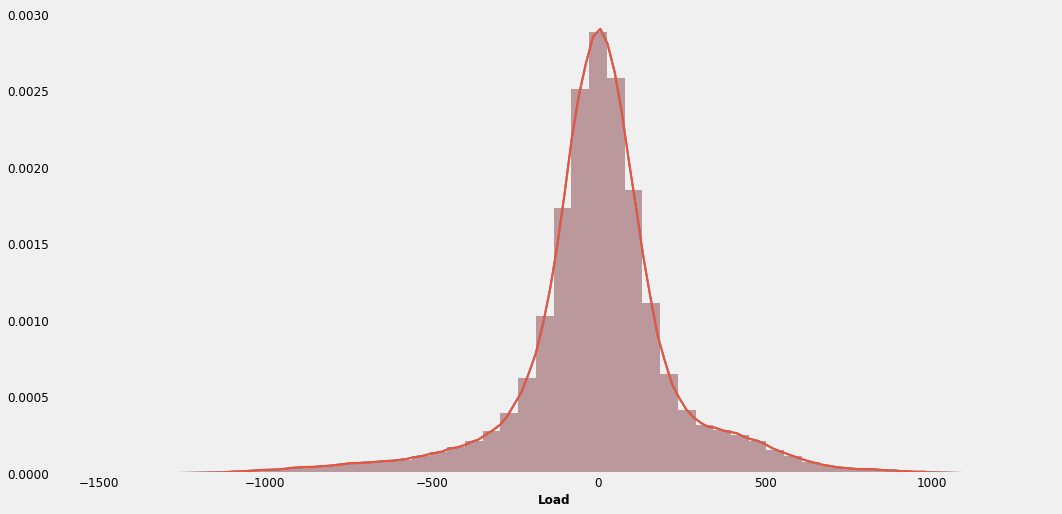

3.7


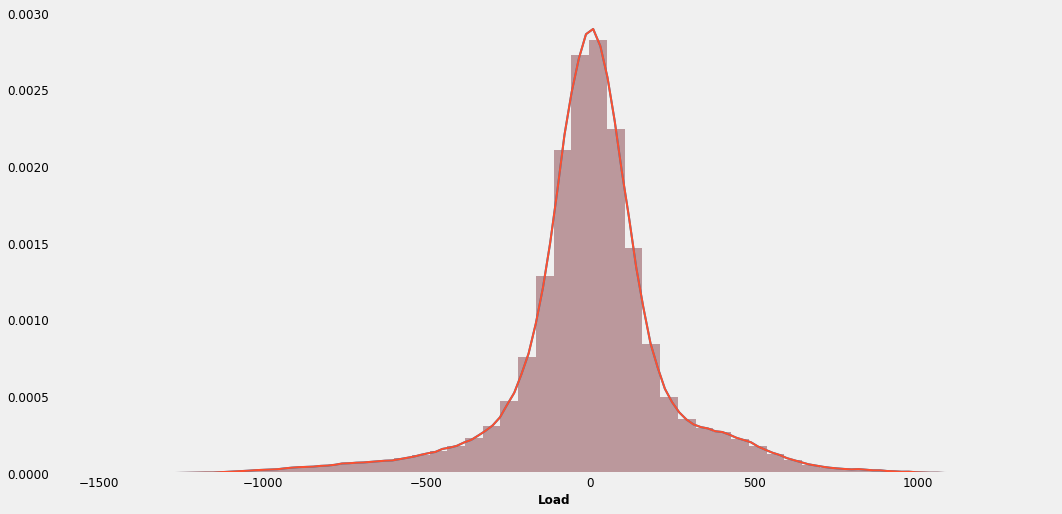

3.8000000000000003


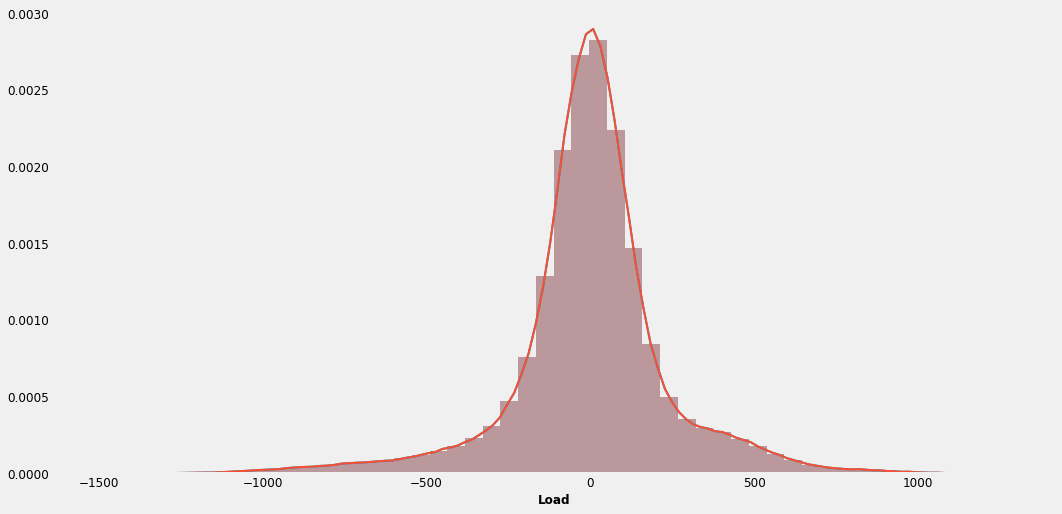

3.9000000000000004


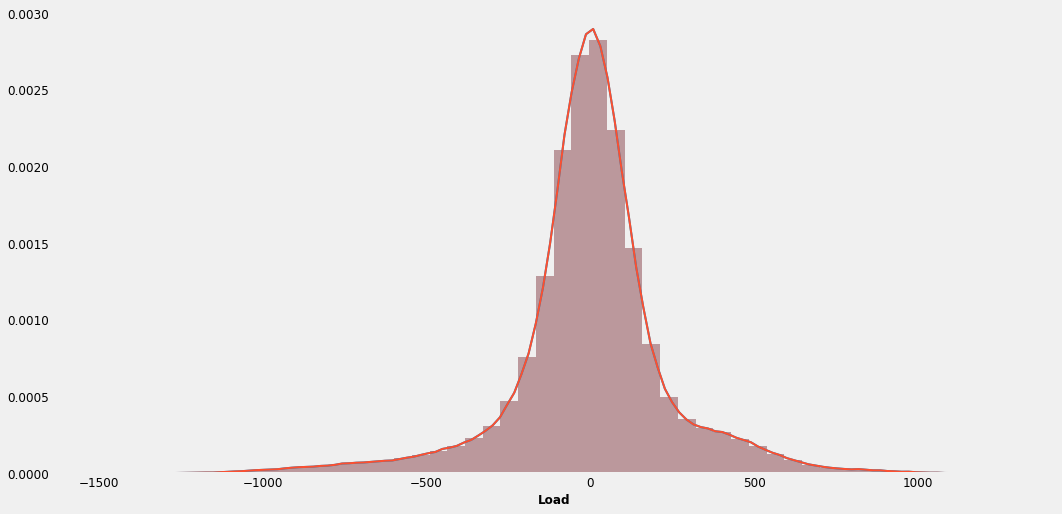

4.0


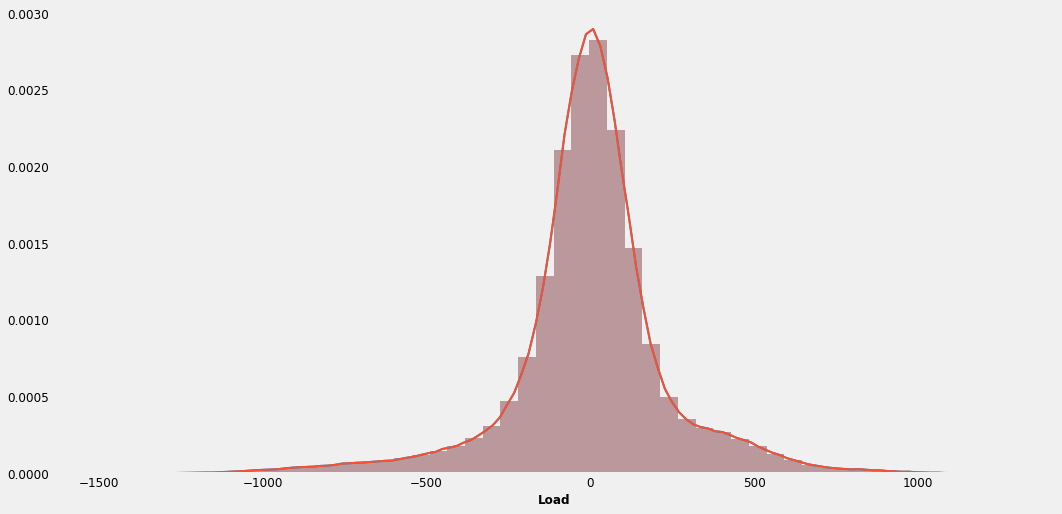

4.1000000000000005


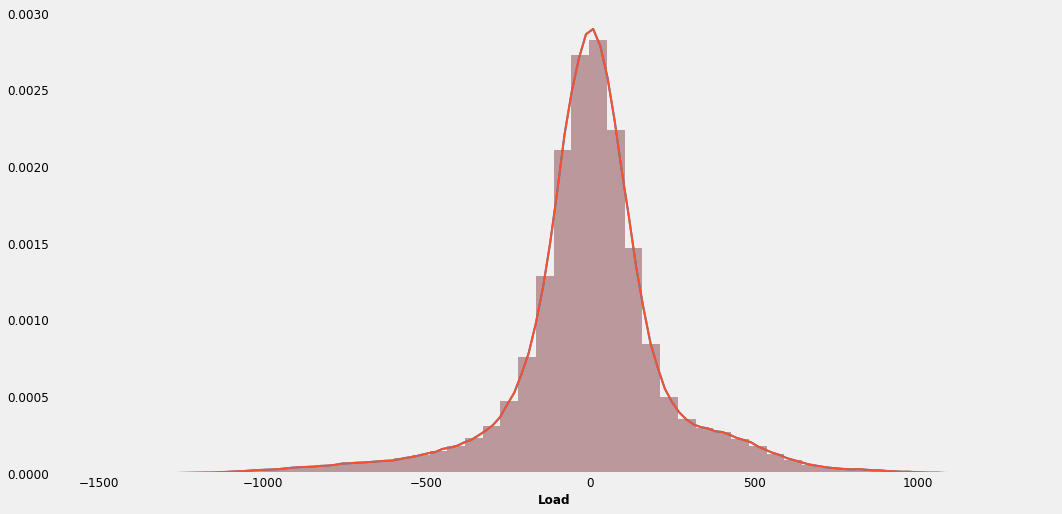

4.2


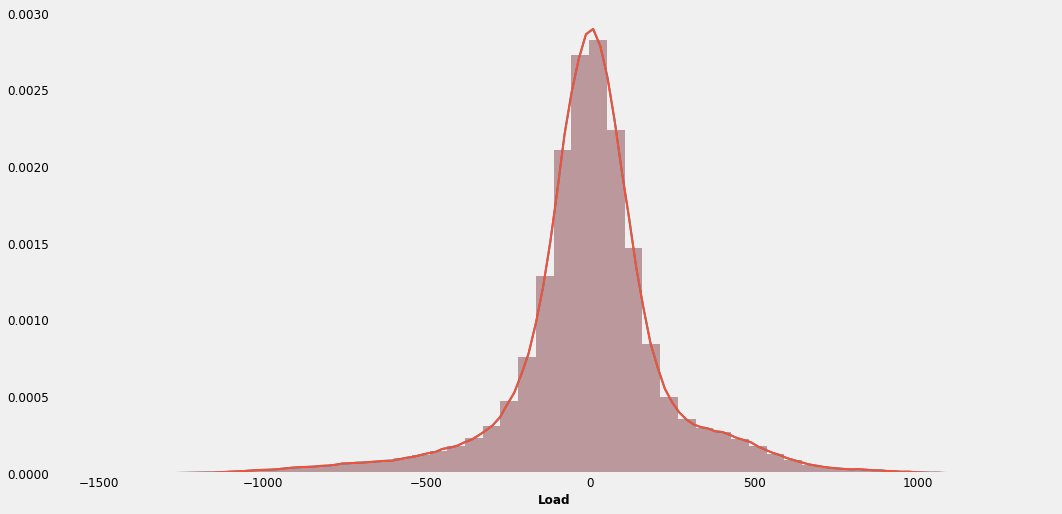

4.3


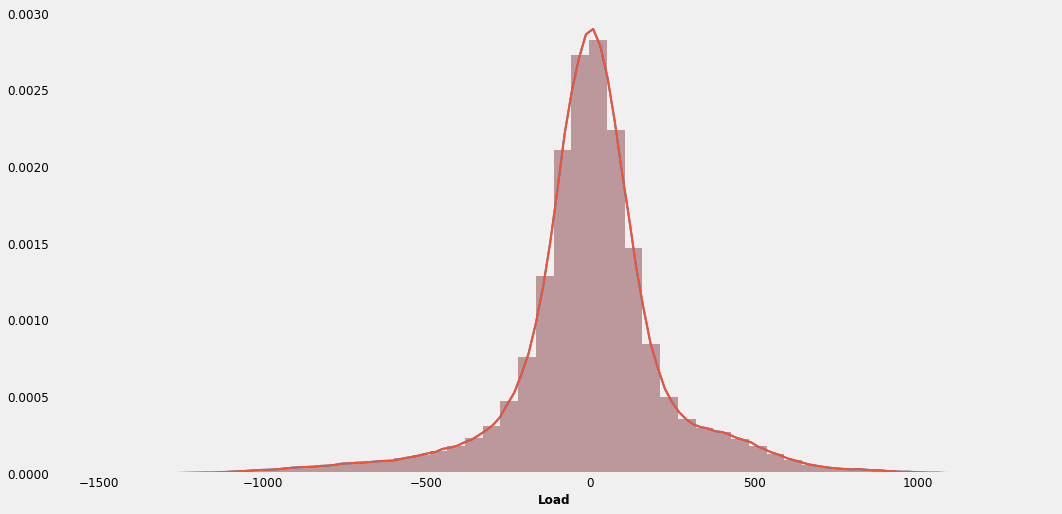

4.4


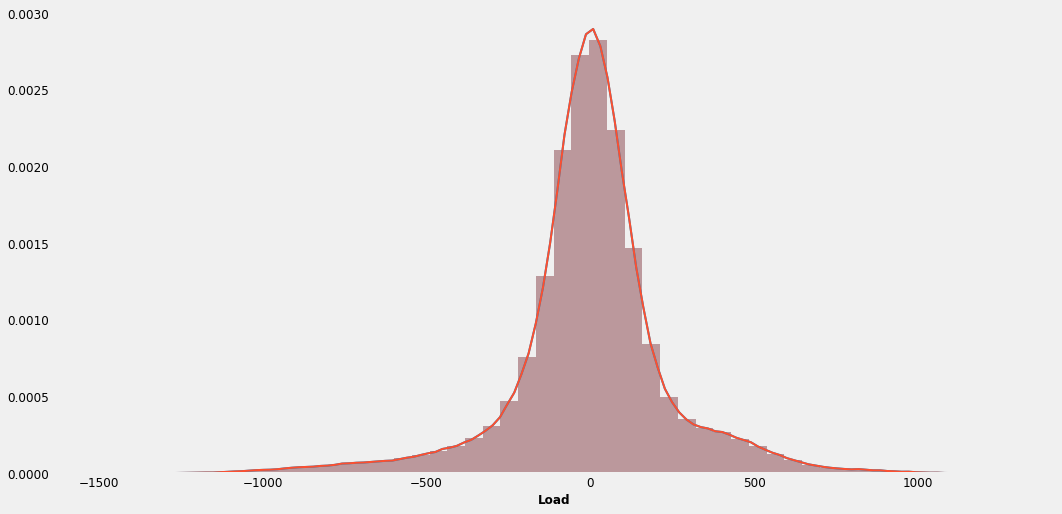

4.5


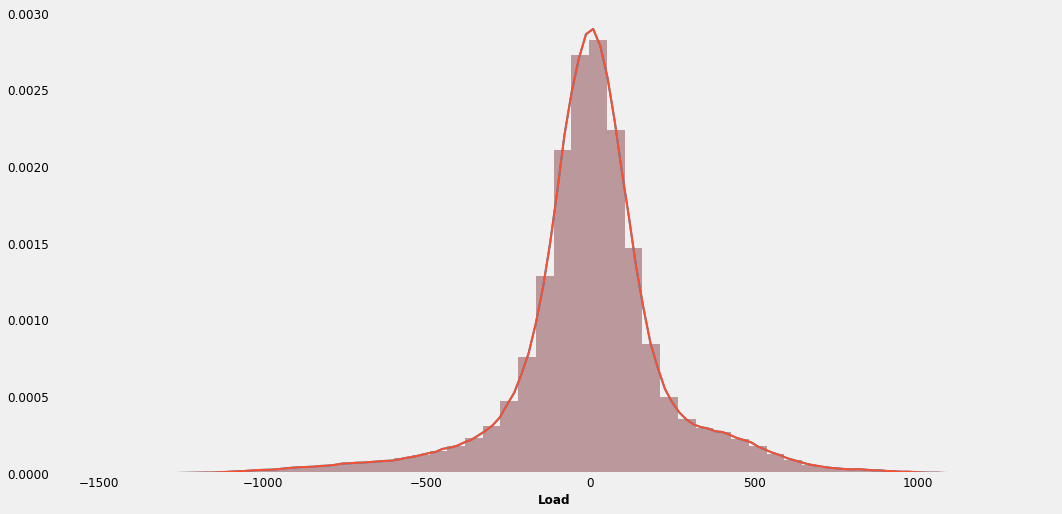

4.6000000000000005


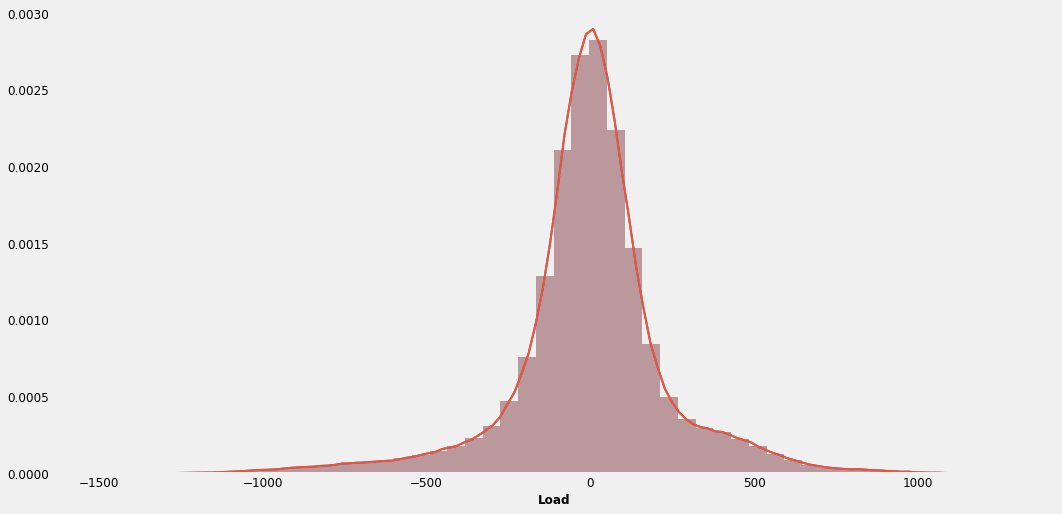

4.7


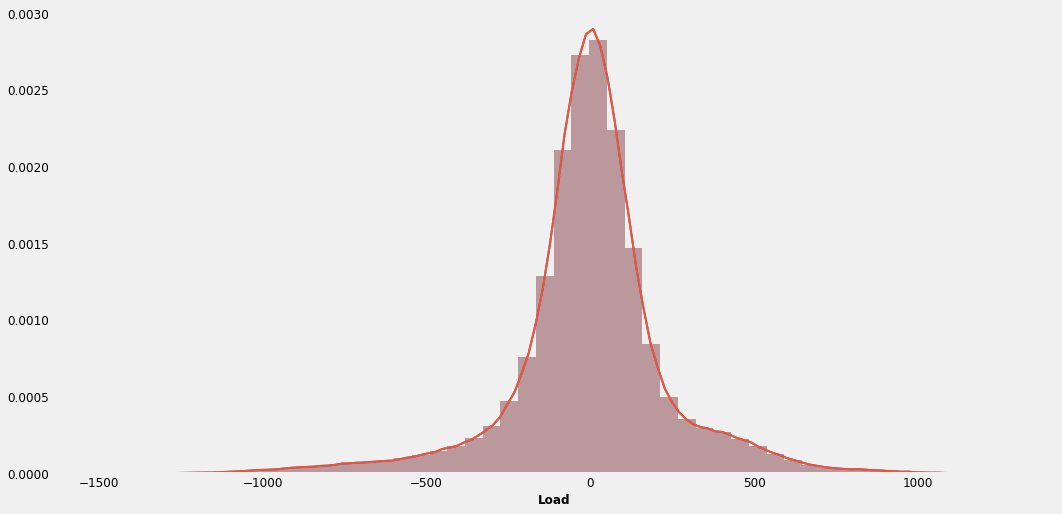

4.800000000000001


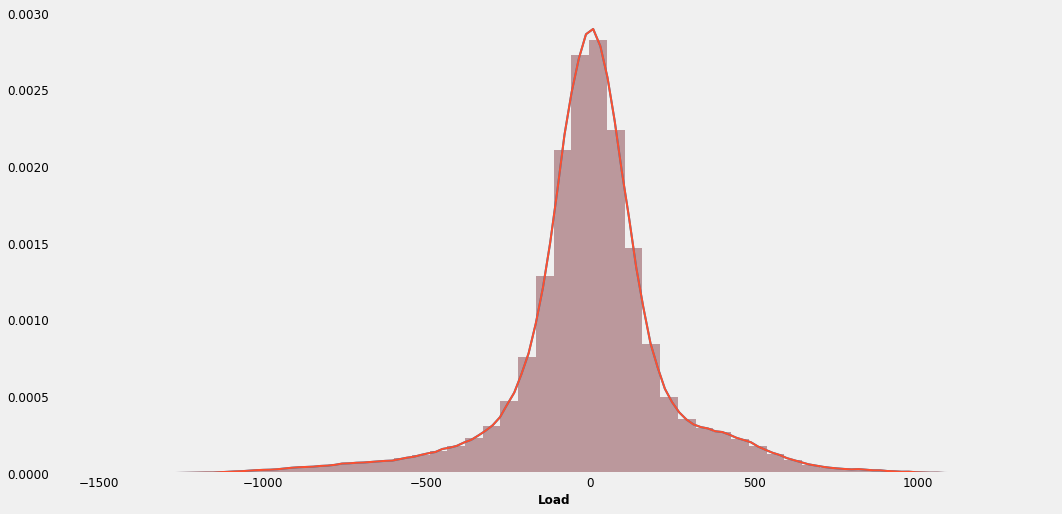

4.9


In [493]:

SIGMA=np.arange(0.,5.0,0.1)
PS=[]
for s in SIGMA:
    res=recons_from_th(s)-data.Load
    X=sns.distplot(res).get_lines()[0].get_data()[0]
    Y=sns.distplot(res).get_lines()[0].get_data()[1]
    #plt.Xticks(np.arange(-1000,1000,100))
    X=X[np.where(Y>10**-4)]
    Y=Y[np.where(Y>10**-4)]
    val_medio=X[int(len(X)/2)]
    n = len(X)                       #the number of data
    mean = sum(X*Y)/n                   #note this correction
    sigma = sum(Y*(X-val_medio)**2)/n        #note this correction
    p0 = [max(Y),val_medio,10]
    popt,pcov = curve_fit(gaus,X,Y,p0=p0)
    #fig, (aX1, aX2) = plt.subplots(2, 1)
    #aX1.set_Ylabel('IntensitY [ADU]')
    #aX1.plot(X,Y,'b+:',label='data')
    #plt.Ylabel('Residuals')
    #aX1.plot(X,gaus(X,*popt),'ro:',label='fit')
    #aX1.legend()
    #res = Y - gaus(X,*popt)
    #aX2.plot(res)
    #plt.show()
    #print(chisquare(Y,gaus(X,*popt))[0])
    #print(chisquare(Y,gaus(X,*popt))[1])
    #print(popt[1])
    PS.append(chisquare(Y,gaus(X,*popt))[1])
    plt.show()
    print(s)


In [446]:
sigma_ticks=[]
for s in SIGMA:
    string='%.2f'%(s)
    sigma_ticks.append(str('$\sigma$ ')+str('$\cdot$')+string)

Text(0.5, 1.0, '$P$-value vs Threshold plot')

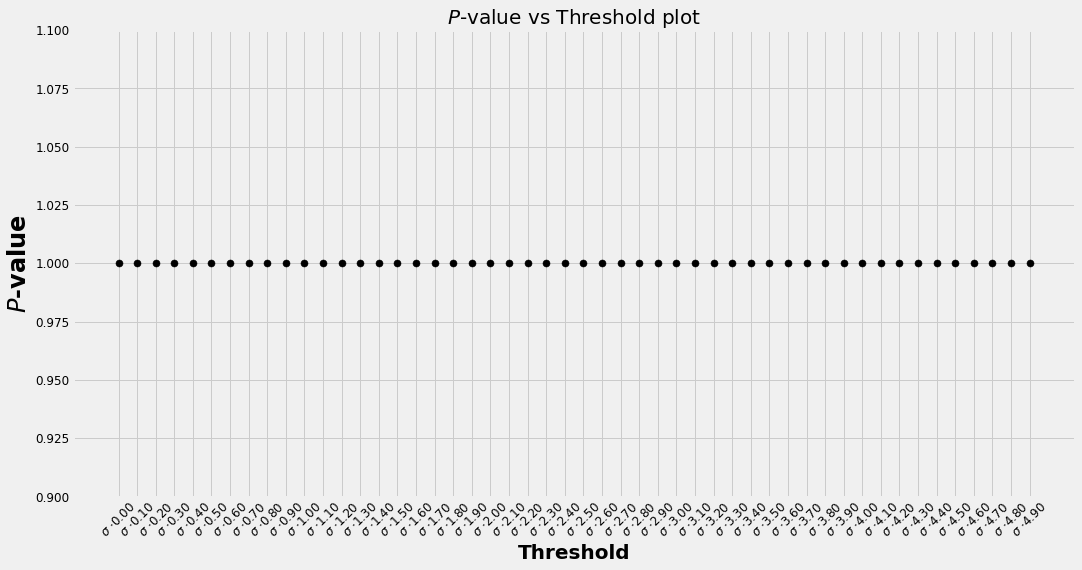

In [447]:
plt.scatter(SIGMA,PS,color='k',s=50)
plt.grid(True)
plt.xlabel('Threshold',fontsize=20)
plt.ylabel('$P$-value',fontsize=24)
plt.xticks(SIGMA,sigma_ticks,rotation=45,fontsize=12)
plt.ylim(0.90,1.10)
plt.title('$P$-value vs Threshold plot',fontsize=20)

In [314]:
def statistics(res):
    X=sns.distplot(res).get_lines()[0].get_data()[0]
    Y=sns.distplot(res).get_lines()[0].get_data()[1]
    #plt.Xticks(np.arange(-1000,1000,100))
    X=X[np.where(Y>10**-4)]
    Y=Y[np.where(Y>10**-4)]
    val_medio=X[int(len(X)/2)]
    n = len(X)                       #the number of data
    mean = sum(X*Y)/n                   #note this correction
    sigma = sum(Y*(X-val_medio)**2)/n        #note this correction
    p0 = [max(Y),val_medio,10]
    popt,pcov = curve_fit(gaus,X,Y,p0=p0)
    #fig, (aX1, aX2) = plt.subplots(2, 1)
    #aX1.set_Ylabel('IntensitY [ADU]')
    #aX1.plot(X,Y,'b+:',label='data')
    #plt.Ylabel('Residuals')
    #aX1.plot(X,gaus(X,*popt),'ro:',label='fit')
    #aX1.legend()
    #res = Y - gaus(X,*popt)
    #aX2.plot(res)
    #plt.show()
    #print(chisquare(Y,gaus(X,*popt))[0])
    #print(chisquare(Y,gaus(X,*popt))[1])
    #print(popt[1])
    return[chisquare(Y,gaus(X,*popt))[0],chisquare(Y,gaus(X,*popt))[1]]


In [292]:
def performance_of_coeff(th):
    rec=coeff_from_th(th)
    dist=coeff_distribution(rec)
    return statistics(dist[0],dist[1])

In [325]:
def performance(th):
    res=recons_from_th(th)-data.Load
    return statistics(res)

[0.1728300520285183, 1.0]

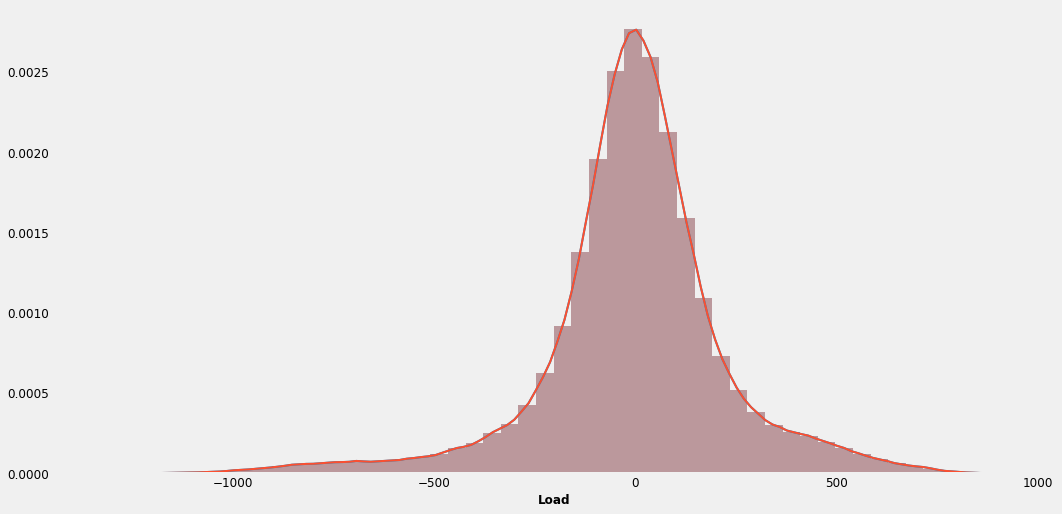

In [328]:
performance(0.0)

In [326]:
PERF

[0.1728300520285183,
 0.1728300520285183,
 0.1728300520285183,
 0.1728300520285183,
 0.1728300520285183,
 0.1728300520285183,
 0.1728300520285183]

In [329]:
SIGMAS

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

[0.1728300520285183, 1.0]
0.0 10
[0.1728300520285183, 1.0]
1.0 10
[0.1728300520285183, 1.0]
2.0 10
[0.1728300520285183, 1.0]
3.0 10
[0.1728300520285183, 1.0]
4.0 10
[0.1728300520285183, 1.0]
5.0 10
[0.1728300520285183, 1.0]
6.0 10
[0.1728300520285183, 1.0]
7.0 10
[0.1728300520285183, 1.0]
8.0 10
[0.1728300520285183, 1.0]
9.0 10


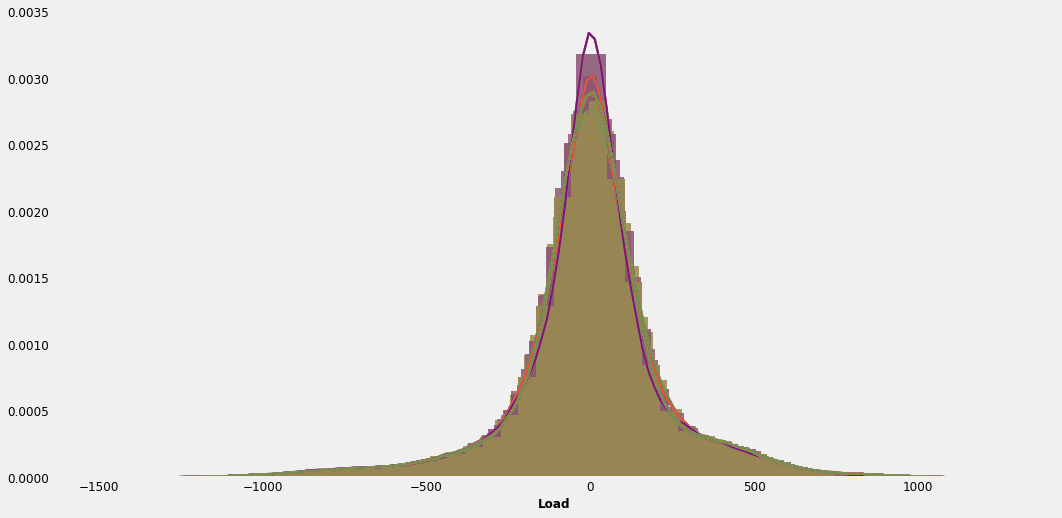

In [331]:
SIGMAS=np.arange(0.0,10,1)
PERF=[]
COEF_PERF=[]
for sigma in SIGMAS:
    print(performance(sigma))
    print(sigma,len(SIGMAS))
    PERF.append(performance(sigma)[0])

In [83]:
opt_sigma=SIGMAS[np.array(COEF_PERF).argmin()]

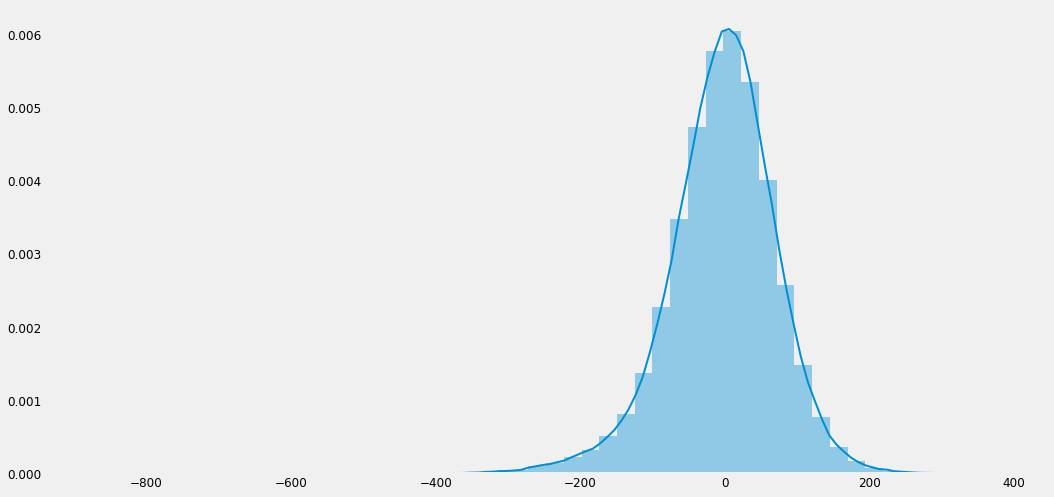

In [84]:
sns.distplot(coeff_from_th(opt_sigma))

In [104]:
opt_recons=(np.repeat(DATASET[0],2)+coeff_from_th(opt_sigma))*(week.Load.max())/(np.repeat(DATASET[0],2)+coeff_from_th(opt_sigma)).max()
MAX=(COEFF_D[0]+DATASET[0]).max()
#opt_recons=np.repeat(DATASET[0],2)+coeff_from_th(opt_sigma)*(week.Load.max())/MAX


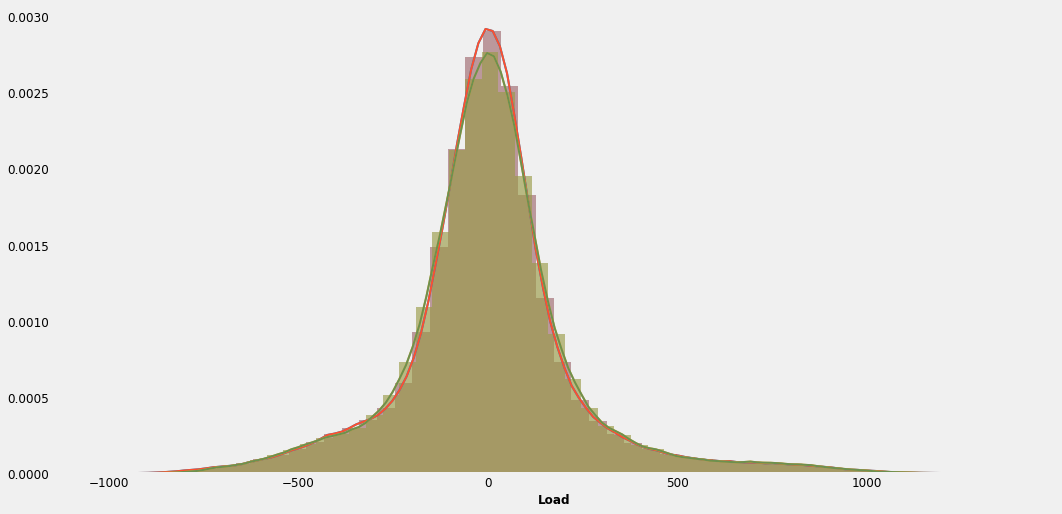

In [131]:
opt_res=week.Load-opt_recons
or_res=week.Load-np.repeat(COEFF_D[0],2)*(week.Load.max())/MAX-np.repeat(DATASET[0],2)*(week.Load.max())/MAX
x_1=sns.distplot(opt_res).get_lines()[0].get_data()[0]
y_1=sns.distplot(opt_res).get_lines()[0].get_data()[1]
x=sns.distplot(or_res).get_lines()[0].get_data()[0]
y=sns.distplot(or_res).get_lines()[0].get_data()[1]

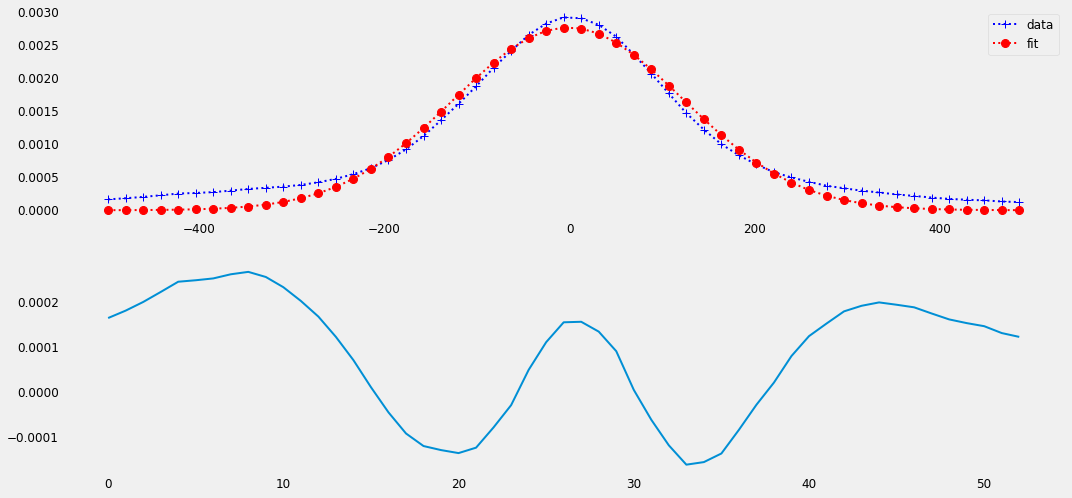

0.12984259313202015
1.0
-1.1759210960385102


In [136]:
x_1_try_1=x_1.round().astype(int)
b=x_1_try_1.tolist().index(505)
a=x_1_try_1.tolist().index(-499)
x_1=x_1[a:b]
y_1=y_1[a:b]

#x_1=sns.distplot(COEFF_D[0]).get_lines()[0].get_data()[0][a:b]
#y_1=sns.distplot(COEFF_D[0]).get_lines()[0].get_data()[1][a:b]
val_medio=0
n = len(x_1)                       #the number of data
mean = sum(x_1*y_1)/n                   #note this correction
sigma = sum(y_1*(x_1-val_medio)**2)/n        #note this correction
p0 = [max(y_1),val_medio,10]
popt,pcov = curve_fit(gaus,x_1,y_1,p0=p0)
fig, (ax_11, ax_12) = plt.subplots(2, 1)
#ax_11.set_y_1_label('Intensity_1 [ADU]')
ax_11.plot(x_1,y_1,'b+:',label='data')
#plt.y_1label('Residuals')
ax_11.plot(x_1,gaus(x_1,*popt),'ro:',label='fit')
ax_11.legend()
res = y_1 - gaus(x_1,*popt)
ax_12.plot(res)
plt.show()
print(chisquare(y_1,gaus(x_1,*popt))[0])
print(chisquare(y_1,gaus(x_1,*popt))[1])
print(popt[1])

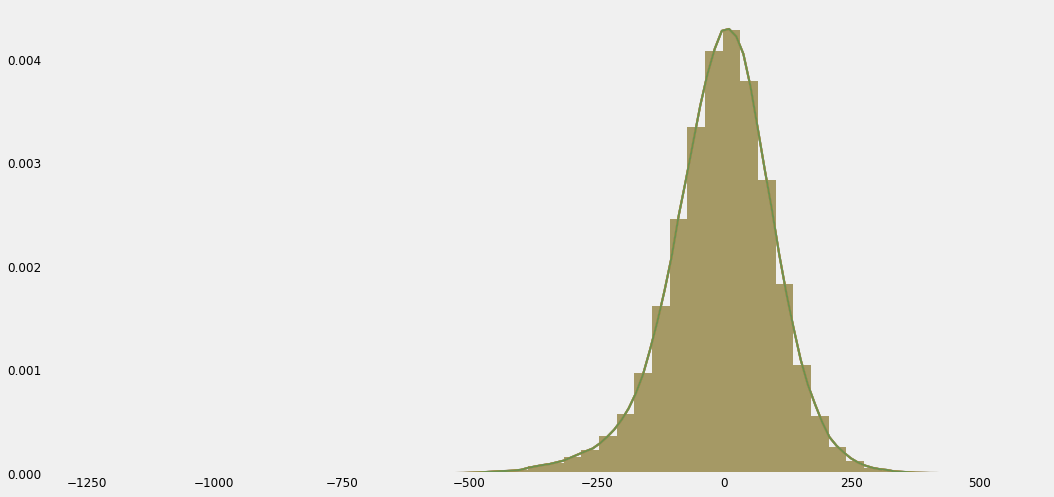

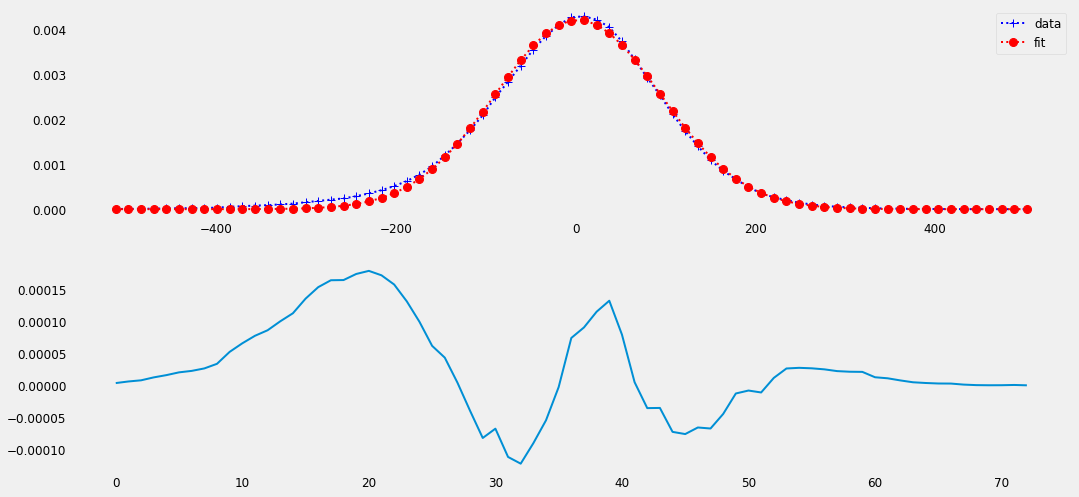

0.14313400606914106
1.0
2.5357406445073667


In [127]:
x_1=sns.distplot(COEFF_D[0]).get_lines()[0].get_data()[0]
y_1=sns.distplot(COEFF_D[0]).get_lines()[0].get_data()[1]
x_1_try_1=x_1.round().astype(int)
b=x_1_try_1.tolist().index(516)
a=x_1_try_1.tolist().index(-511)
x_1=x_1[a:b]
y_1=y_1[a:b]

x_1=sns.distplot(COEFF_D[0]).get_lines()[0].get_data()[0][a:b]
y_1=sns.distplot(COEFF_D[0]).get_lines()[0].get_data()[1][a:b]
val_medio=x_1[int(len(x_1)/2)]
n = len(x_1)                       #the number of data
mean = sum(x_1*y_1)/n                   #note this correction
sigma = sum(y_1*(x_1-val_medio)**2)/n        #note this correction
p0 = [max(y_1),val_medio,10]
popt,pcov = curve_fit(gaus,x_1,y_1,p0=p0)
fig, (ax_11, ax_12) = plt.subplots(2, 1)
#ax_11.set_y_1_label('Intensity_1 [ADU]')
ax_11.plot(x_1,y_1,'b+:',label='data')
#plt.y_1label('Residuals')
ax_11.plot(x_1,gaus(x_1,*popt),'ro:',label='fit')
ax_11.legend()
res = y_1 - gaus(x_1,*popt)
ax_12.plot(res)
plt.show()
print(chisquare(y_1,gaus(x_1,*popt))[0])
print(chisquare(y_1,gaus(x_1,*popt))[1])
print(popt[1])